# **The Real Deal Behind the Artificial Appeal: Inferential Utility of Tabular Synthetic Data**

Results of the simulation study in "The Real Deal Behind the Artificial Appeal: Inferential Utility of Tabular Synthetic Data", presented during the 40th Conference on Uncertainty in Artificial Intelligence.

**(c) SYNDARA**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
from utils.disease import ground_truth
from utils.eval import missing_se, plot_bias, plot_convergence_rate, table_convergence_rate, summary_table, plot_type_I_II_error

## Load meta data

In [3]:
sim_dir = 'simulation_study1/'
meta_data = pd.read_csv(sim_dir + 'meta_data.csv')

In [4]:
data_gt, data_rescale = ground_truth()

## Inspect meta data

In [5]:
meta_data.shape

(10997, 129)

5 sample sizes, 200 Monte Carlo runs, 1 original dataset, 10 generative models with 1 synthetic dataset per model, so 5x200x(1+10x1)=11000 datasets. However, 'ctgan' (synthcity), 'dpgan' and 'pategan' could not be fitted for [n=500, run=50], so 11000-1*3=10997 datasets (without DP generators: 7999 datasets; with DP generators: 10997 datasets).

In [6]:
meta_data.head()

dataset_name   n    run         generator   age_mean  age_mean_se  \
0          synthpop_0  50  run_0          synthpop  52.120832     1.218508   
1         privbayes_0  50  run_0         privbayes  49.054470     1.346774   
2  bayesian_network_0  50  run_0  bayesian_network  52.509614     1.527606   
3      custom_ctgan_0  50  run_0      custom_ctgan  54.062986     2.076321   
4              tvae_0  50  run_0              tvae  54.435660     0.743607   

      age_sd     age_var  biomarker_mean  biomarker_mean_se  ...  \
0   8.616155   74.238121        0.627538           0.054681  ...   
1   9.523133   90.690058        0.521957           0.048851  ...   
2  10.801802  116.678931        0.576207           0.048295  ...   
3  14.681807  215.555458        0.643891           0.055122  ...   
4   5.258094   27.647549        0.610111           0.052131  ...   

   death_stage_IV_logr_bias  death_stage_IV_logr_NHST_type1  \
0                 -0.332854                           False   
1                 -2.821602                            True   
2                  0.453953                           False   
3                  2.631804                            True   
4                 -1.645072                            True   

   death_stage_IV_logr_NHST_type1_corrected  death_stage_IV_logr_NHST_type2  \
0                                     False                            True   
1                                      True                           False   
2                                     False                            True   
3                                     False                           False   
4                                     False                           False   

   death_stage_IV_logr_NHST_type2_corrected  death_therapy_logr_bias  \
0                                      True                 0.959406   
1                                     False                -0.582295   
2                                      True                 1.561222   
3                                      True                 0.443644   
4                                      True                 1.522884   

   death_therapy_logr_NHST_type1  death_therapy_logr_NHST_type1_corrected  \
0                          False                                    False   
1                          False                                    False   
2                           True                                    False   
3                          False                                    False   
4                           True                                    False   

   death_therapy_logr_NHST_type2  death_therapy_logr_NHST_type2_corrected  
0                           True                                     True  
1                           True                                     True  
2                          False                                     True  
3                           True                                     True  
4                          False                                     True  

[5 rows x 129 columns]

## Missing estimates

**Tables (appendix)**

In [7]:
data_missing = missing_se(meta_data)
order_columns = ['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae', 'All']

In [8]:
pd.crosstab(data_missing.query(f'generator in {order_columns}')['estimator'], data_missing.query(f'generator in {order_columns}')['n'], margins=True)

n                             50  160  500  All
estimator                                      
biomarker_stage_III_gamr_se    7    0    0    7
biomarker_stage_II_gamr_se    11    0    0   11
biomarker_stage_IV_gamr_se    16    0    0   16
death_stage_III_logr_se      116    3    1  120
death_stage_II_logr_se        91    1    5   97
death_stage_IV_logr_se       180    2    3  185
death_therapy_logr_se         11    0    0   11
stage_III_prop_se              7    0    0    7
stage_II_prop_se              11    0    0   11
stage_IV_prop_se              16    0    0   16
All                          466    6    9  481

In [9]:
pd.crosstab(data_missing.query(f'generator in {order_columns}')['n'], data_missing.query(f'generator in {order_columns}')['generator'], margins=True)[order_columns]

generator  original  synthpop  bayesian_network  bayesian_network_DAG  ctgan  \
n                                                                              
50               19        48                57                     4    137   
160               0         0                 0                     0      5   
500               0         0                 0                     0      9   
All              19        48                57                     4    151   

generator  custom_ctgan  tvae  custom_tvae  All  
n                                                
50                   23    91           87  466  
160                   0     1            0    6  
500                   0     0            0    9  
All                  23    92           87  481

## Average IKLD

**Table (appendix)**

In [10]:
order_generators = ['synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae']
meta_data.groupby(['n', 'generator'])['sanity_IKLD'].mean().reset_index().melt(
    id_vars=['n', 'generator'],
    var_name='estimator',
    value_name='IKLD').pivot(index='generator', columns='n', values='IKLD').loc[order_generators].style.format(precision=3)

## Bias and consistency

**Plot (main text)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



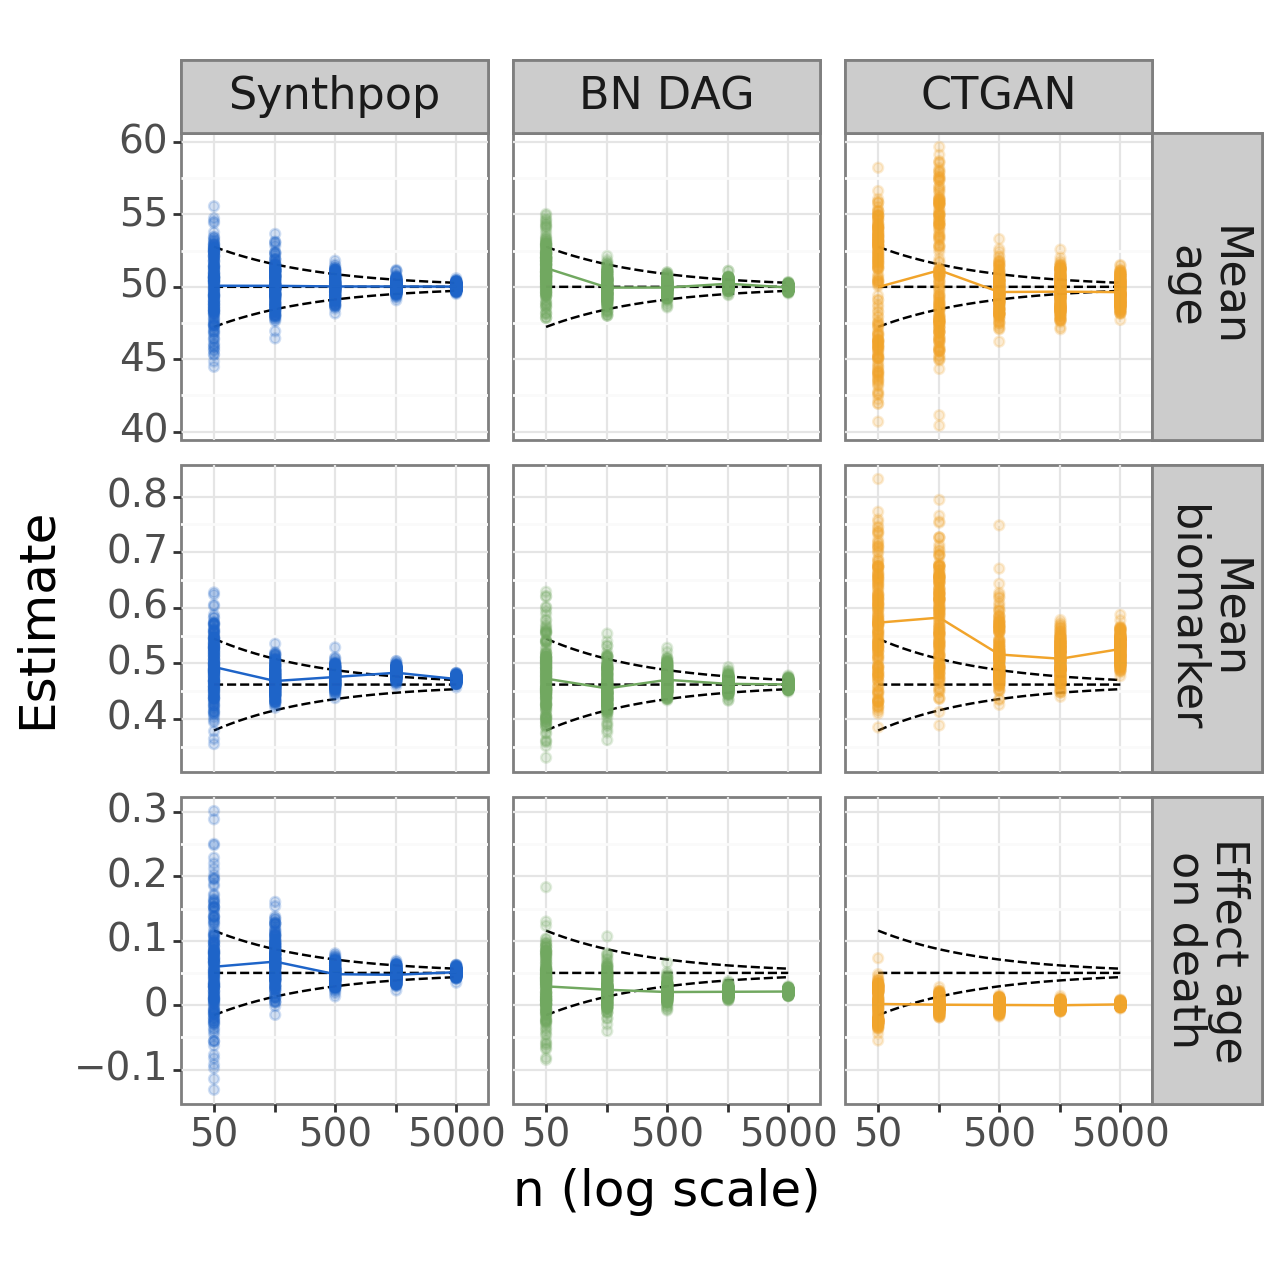

<Figure Size: (637 x 637)>

In [12]:
# Relabel
relabel_estimators = {'age_mean': 'Mean\nage', 
                      'biomarker_mean': 'Mean\nbiomarker',
                      'death_age_logr': 'Effect age\non death'}
relabel_generators = {'synthpop': 'Synthpop', 
                      'bayesian_network_DAG': 'BN DAG',
                      'custom_ctgan': 'CTGAN'}

# Plot
plot_bias(meta_data.query('generator in [\'synthpop\', \'bayesian_network_DAG\', \'custom_ctgan\']'), 
          select_estimators=['age_mean', 'biomarker_mean', 'death_age_logr'], 
          order_generators=['synthpop', 'bayesian_network_DAG', 'custom_ctgan'],
          plot_outliers=True,
          unit_rescale=data_rescale,
          plot_estimates=True,
          ground_truth=data_gt) +\
    facet_grid('estimator ~ generator', scales='free', labeller=labeller(cols=lambda x: relabel_generators[x], rows=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=14), # axis labels size 
          panel_spacing=0.02) # add space between facets

**Plots (appendix)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 34 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 34 rows containing missing values.


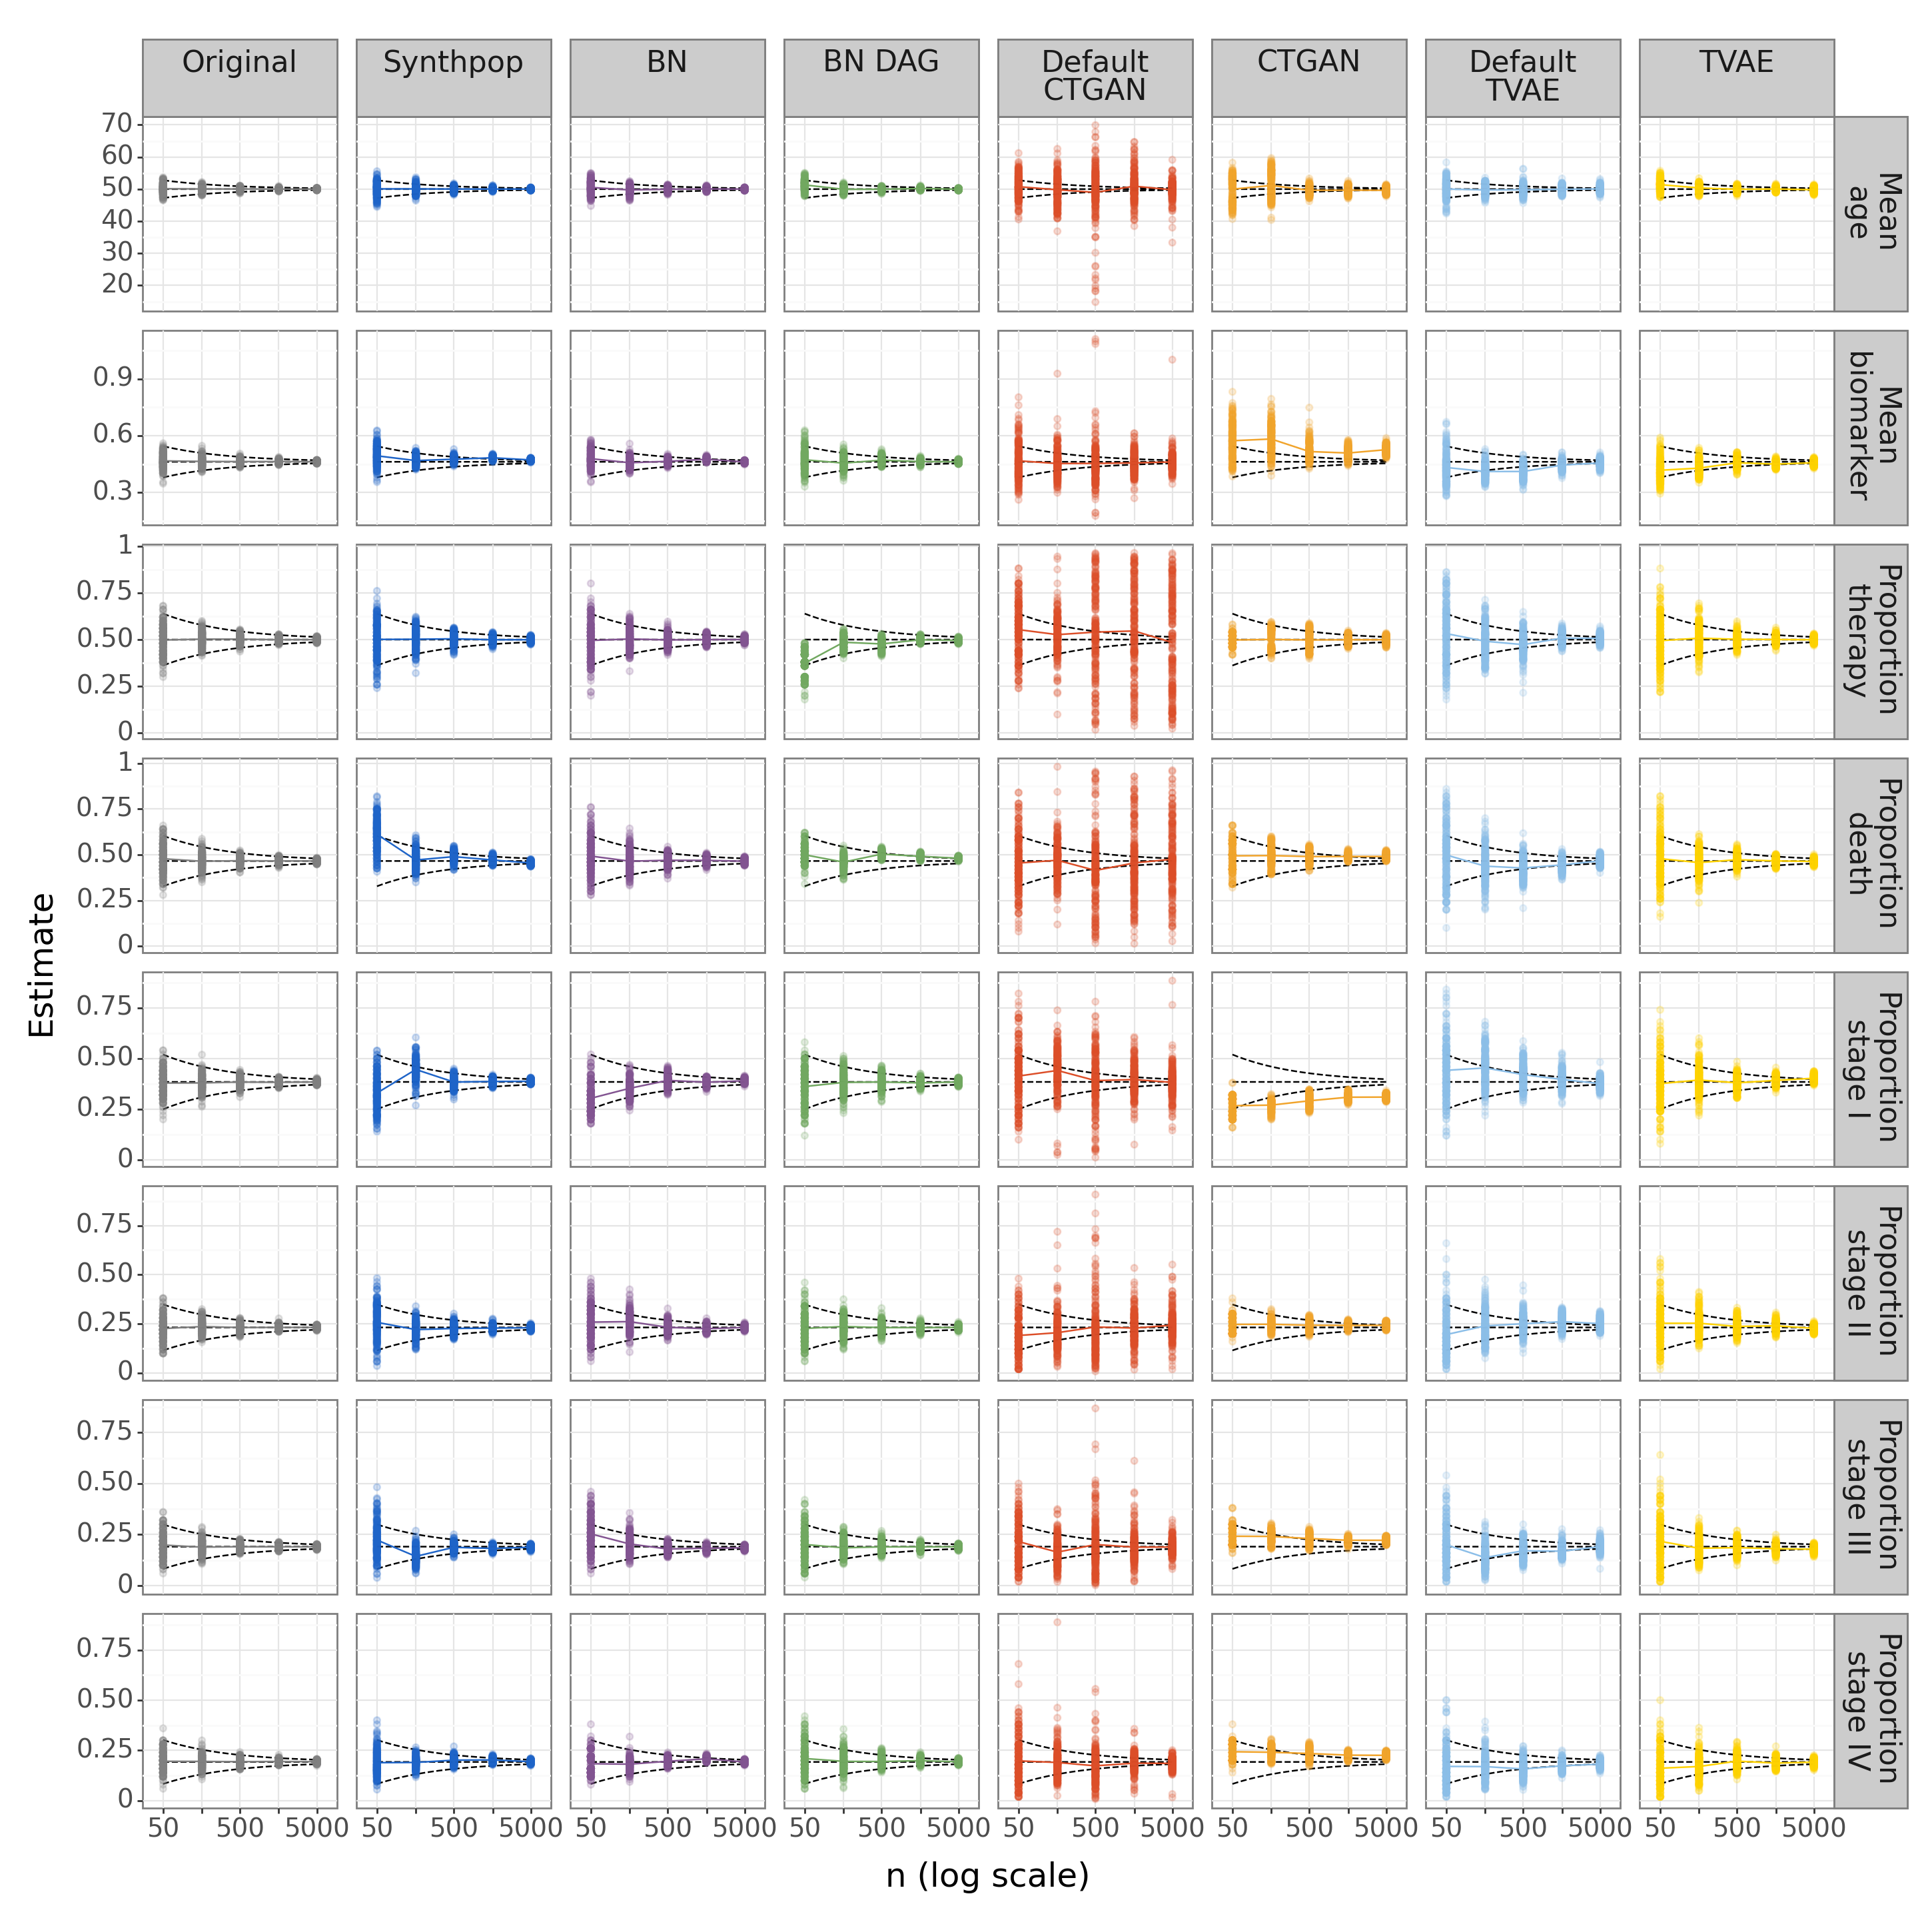

<Figure Size: (1450 x 1450)>

In [13]:
# Relabel
relabel_estimators = {'age_mean': 'Mean\nage', 
                      'biomarker_mean': 'Mean\nbiomarker',
                      'therapy_prop': 'Proportion\ntherapy',
                      'death_prop': 'Proportion\ndeath', 
                      'stage_I_prop': 'Proportion\nstage I',
                      'stage_II_prop': 'Proportion\nstage II',
                      'stage_III_prop': 'Proportion\nstage III',
                      'stage_IV_prop': 'Proportion\nstage IV'}
relabel_generators = {'original': 'Original\n',
                      'synthpop': 'Synthpop\n', 
                      'bayesian_network': 'BN\n',
                      'bayesian_network_DAG': 'BN DAG\n',
                      'ctgan': 'Default\nCTGAN',
                      'custom_ctgan': 'CTGAN\n',
                      'tvae': 'Default\nTVAE',
                      'custom_tvae': 'TVAE\n'}

# Plot
plot_bias(meta_data.query('generator not in [\'privbayes\', \'dpgan\', \'pategan\']'),
          select_estimators=['age_mean', 'biomarker_mean', 
                             'therapy_prop', 'death_prop', 'stage_I_prop', 'stage_II_prop', 'stage_III_prop', 'stage_IV_prop'],
          order_generators=['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae'],
          plot_outliers=True,
          unit_rescale=data_rescale,
          plot_estimates=True,
          ground_truth=data_gt) +\
    facet_grid('estimator ~ generator', scales='free', labeller=labeller(cols=lambda x: relabel_generators[x], rows=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=14)) # axis labels size 

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 447 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 447 rows containing missing values.


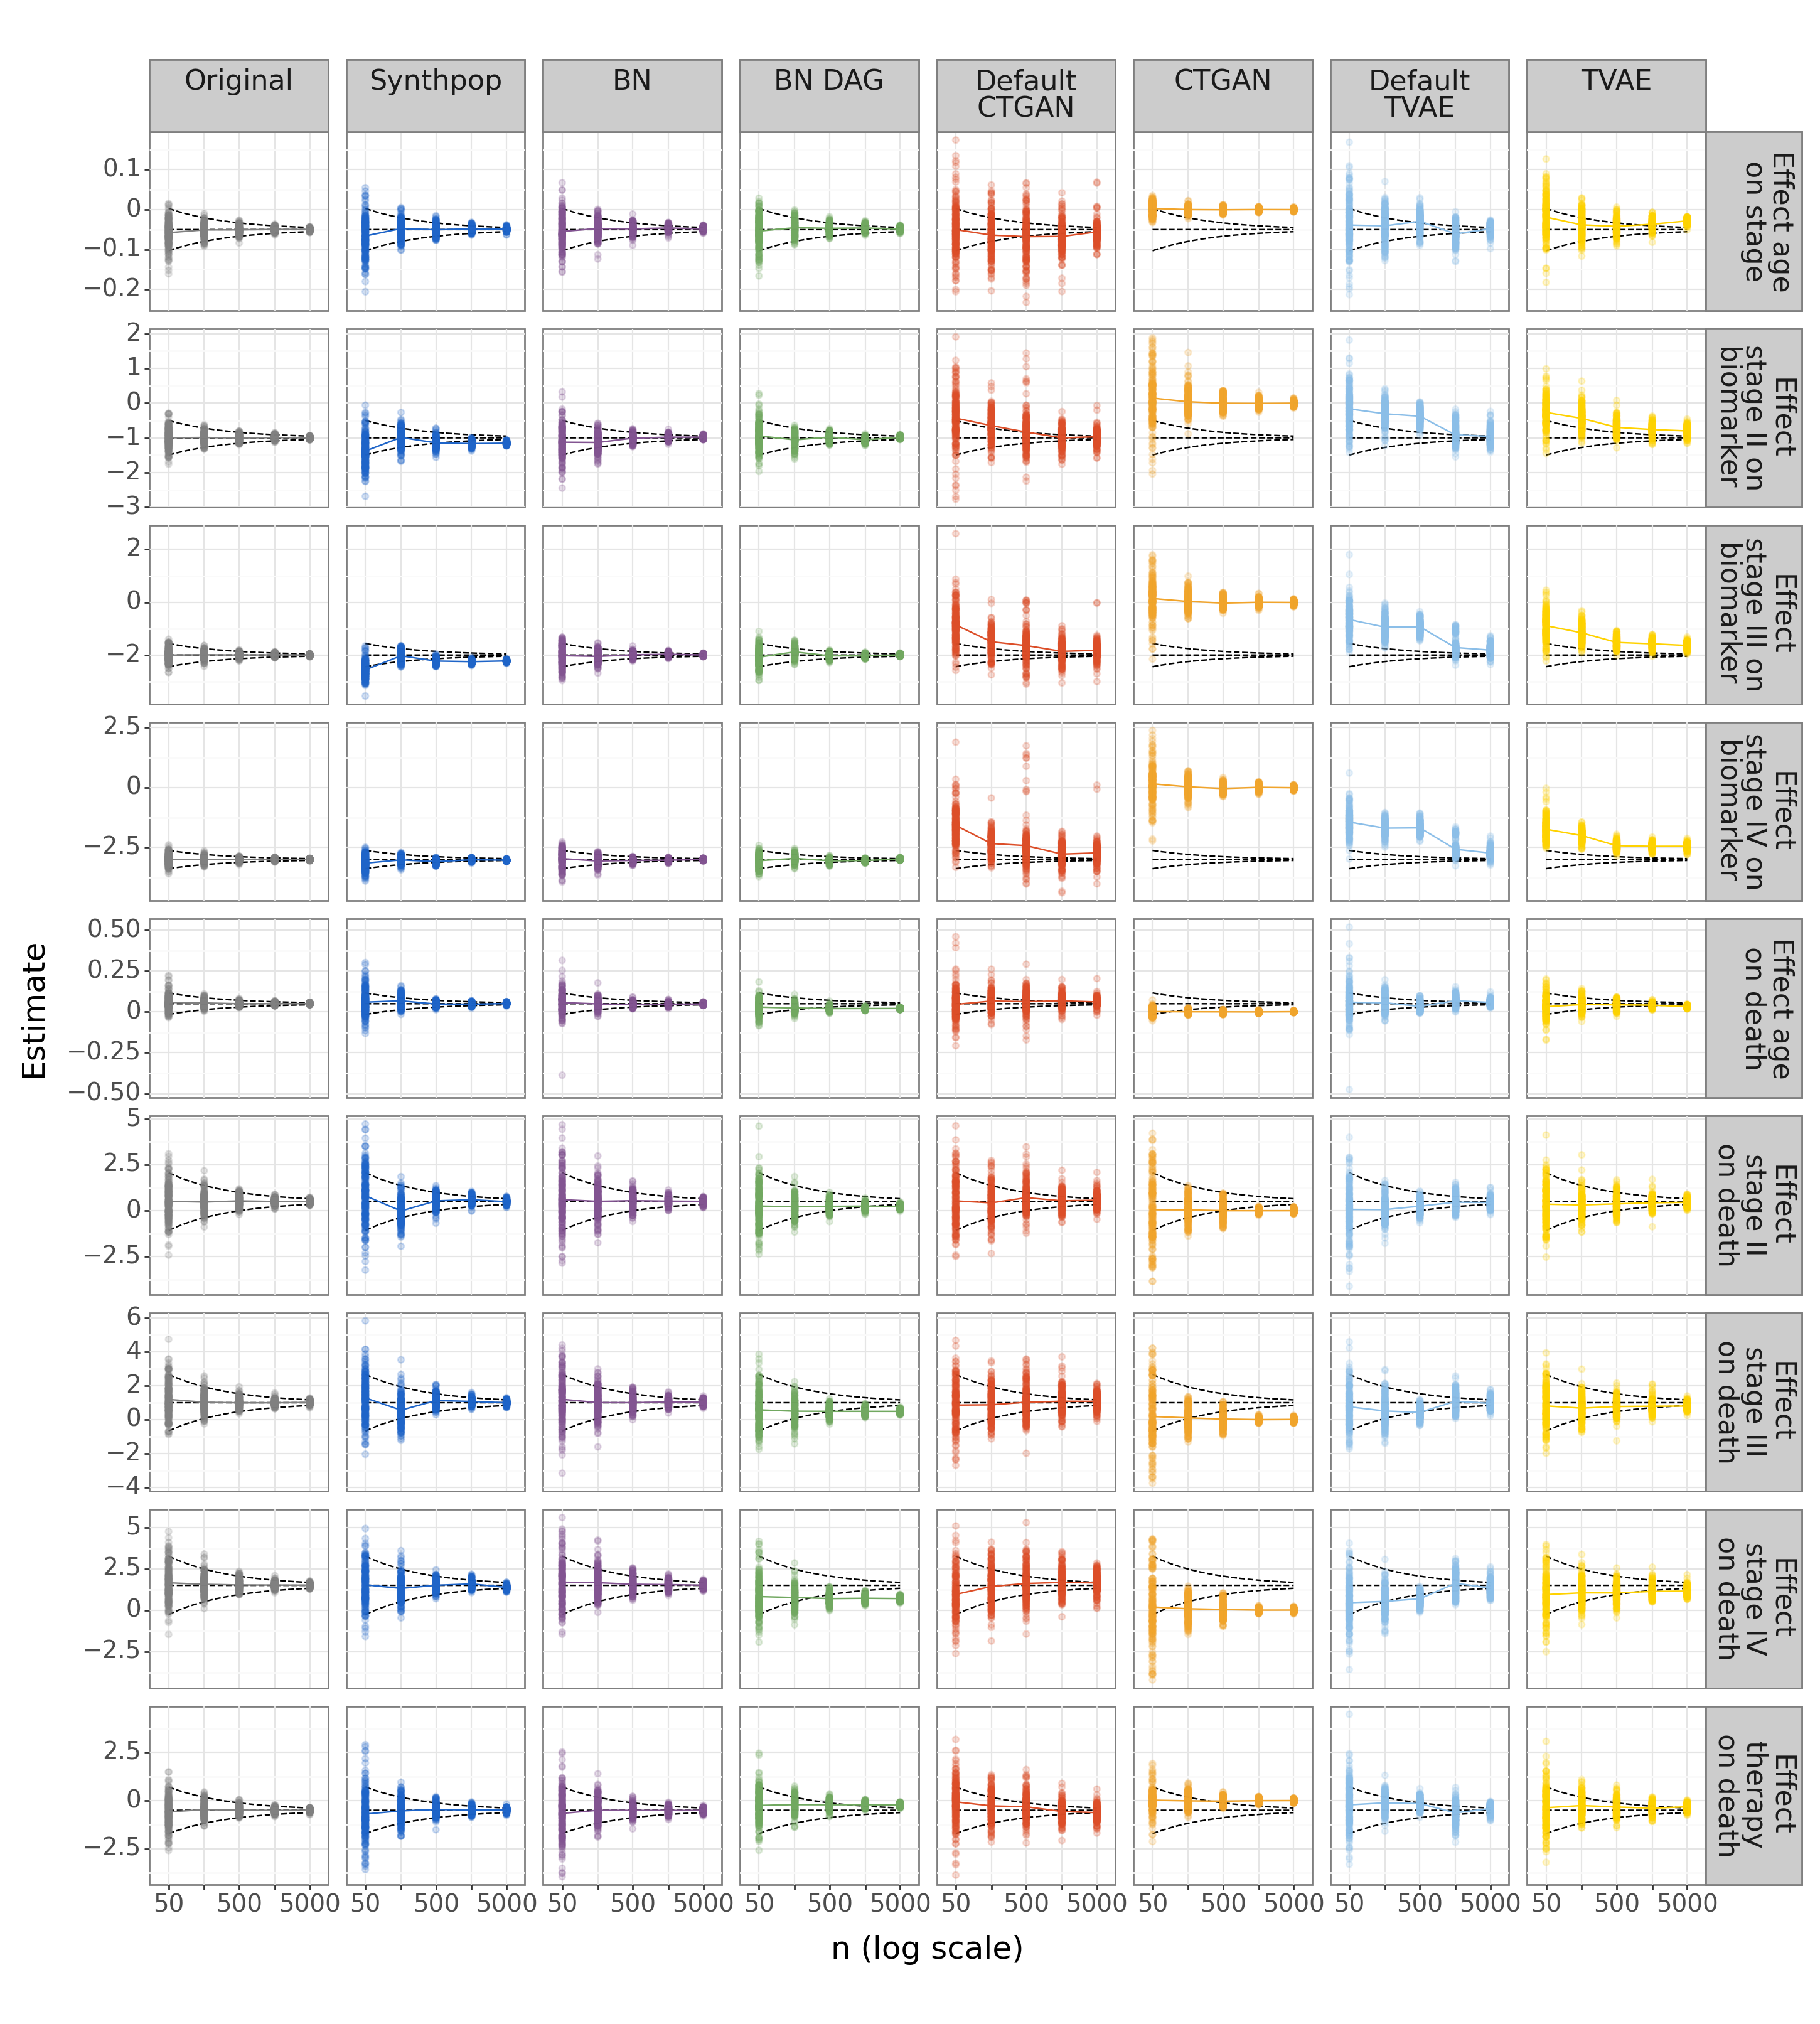

<Figure Size: (1450 x 1612)>

In [14]:
# Relabel
relabel_estimators = {'stage_age_polr': 'Effect age\non stage\n', 
                      'biomarker_stage_II_gamr': 'Effect\nstage II on\nbiomarker',
                      'biomarker_stage_III_gamr': 'Effect\nstage III on\nbiomarker',
                      'biomarker_stage_IV_gamr': 'Effect\nstage IV on\nbiomarker', 
                      'death_age_logr': 'Effect age\non death\n',
                      'death_stage_II_logr': 'Effect\nstage II\non death',
                      'death_stage_III_logr': 'Effect\nstage III\non death',
                      'death_stage_IV_logr': 'Effect\nstage IV\non death',
                      'death_therapy_logr': 'Effect\ntherapy\non death'}
relabel_generators = {'original': 'Original\n',
                      'synthpop': 'Synthpop\n', 
                      'bayesian_network': 'BN\n',
                      'bayesian_network_DAG': 'BN DAG\n',
                      'ctgan': 'Default\nCTGAN',
                      'custom_ctgan': 'CTGAN\n',
                      'tvae': 'Default\nTVAE',
                      'custom_tvae': 'TVAE\n'}

# Plot
plot_bias(meta_data.query('generator not in [\'privbayes\', \'dpgan\', \'pategan\']'),
          select_estimators=['stage_age_polr',
                             'biomarker_stage_II_gamr', 'biomarker_stage_III_gamr', 'biomarker_stage_IV_gamr',
                             'death_age_logr', 'death_stage_II_logr', 'death_stage_III_logr', 'death_stage_IV_logr', 'death_therapy_logr'],
          order_generators=['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae'],
          plot_outliers=True,
          unit_rescale=data_rescale,
          plot_estimates=True,
          ground_truth=data_gt) +\
    facet_grid('estimator ~ generator', scales='free', labeller=labeller(cols=lambda x: relabel_generators[x], rows=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=14)) # axis labels size

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 211 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 211 rows containing missing values.


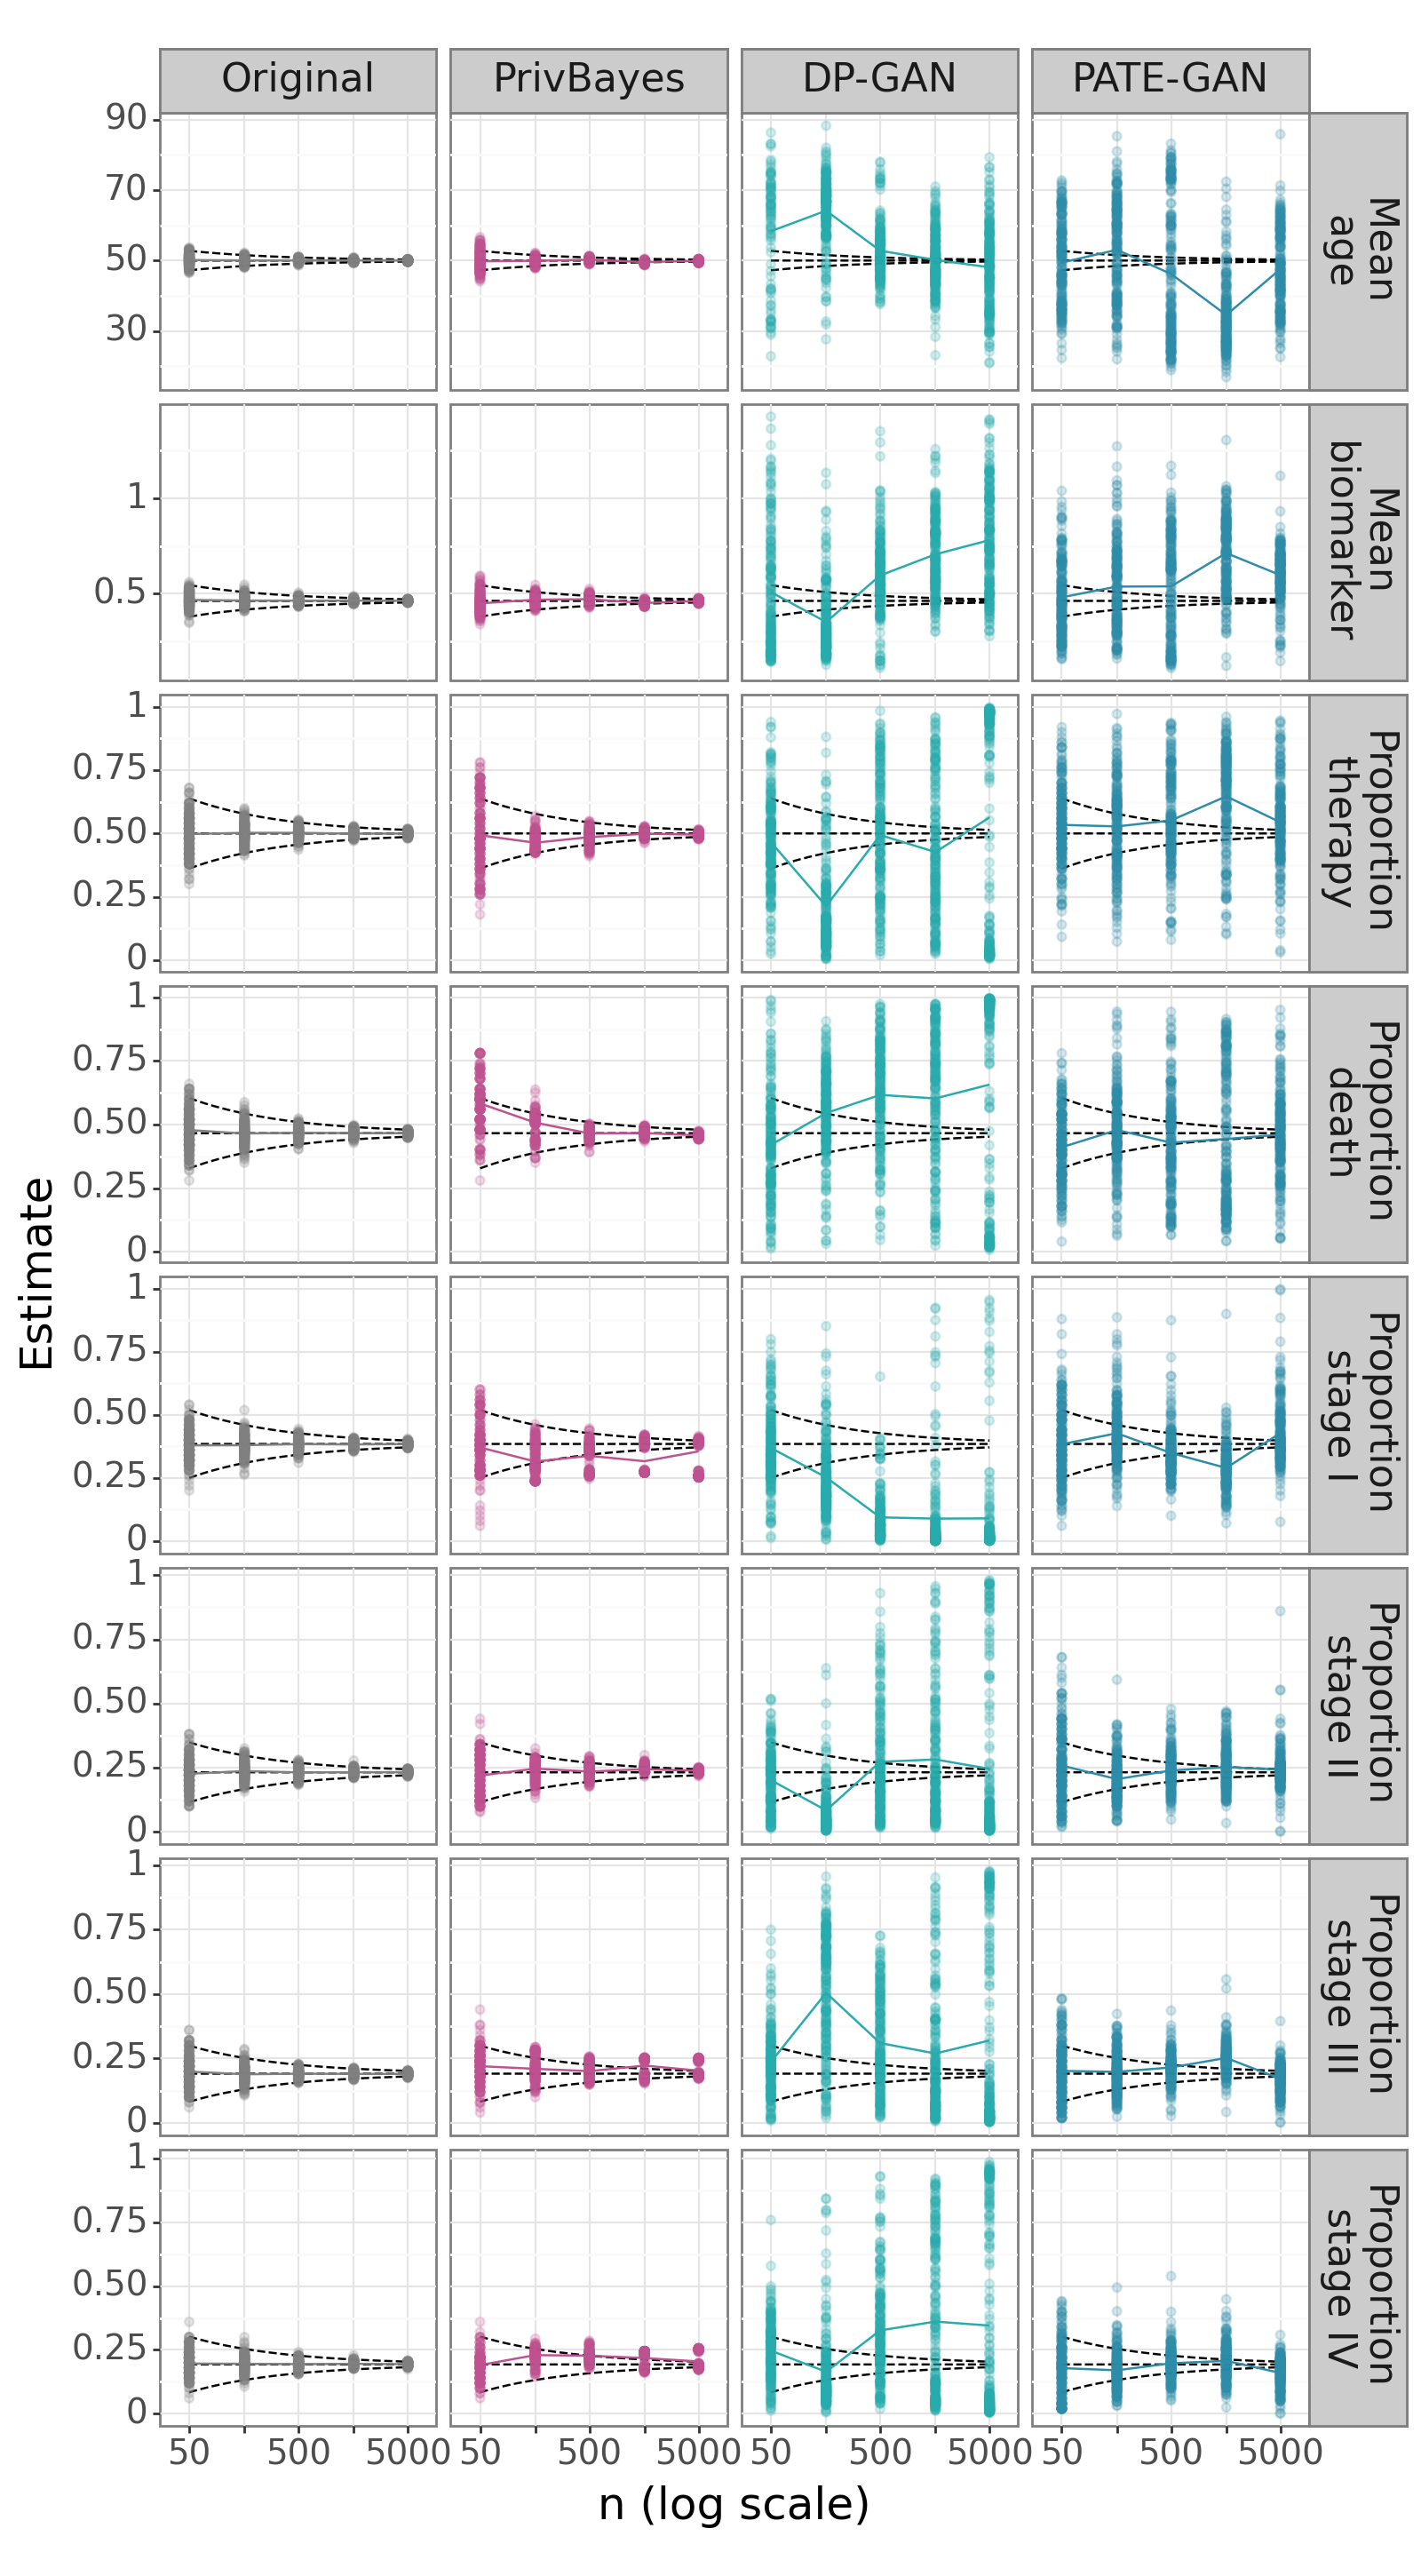

<Figure Size: (800 x 1450)>

In [15]:
# Relabel
relabel_estimators = {'age_mean': 'Mean\nage', 
                      'biomarker_mean': 'Mean\nbiomarker',
                      'therapy_prop': 'Proportion\ntherapy',
                      'death_prop': 'Proportion\ndeath', 
                      'stage_I_prop': 'Proportion\nstage I',
                      'stage_II_prop': 'Proportion\nstage II',
                      'stage_III_prop': 'Proportion\nstage III',
                      'stage_IV_prop': 'Proportion\nstage IV'}
relabel_generators = {'original': 'Original',
                      'privbayes': 'PrivBayes', 
                      'dpgan': 'DP-GAN',
                      'pategan': 'PATE-GAN'}

# Plot
plot_bias(meta_data.query('generator in [\'original\', \'privbayes\', \'dpgan\', \'pategan\']'),
          select_estimators=['age_mean', 'biomarker_mean', 
                             'therapy_prop', 'death_prop', 'stage_I_prop', 'stage_II_prop', 'stage_III_prop', 'stage_IV_prop'],
          order_generators=['original', 'privbayes', 'dpgan', 'pategan'],
          plot_outliers=True,
          unit_rescale=data_rescale,
          plot_estimates=True,
          ground_truth=data_gt) +\
    scale_colour_manual(values={'original': '#808080', 'privbayes': '#BE5190', 'dpgan': '#27ABAD', 'pategan':'#2D8CA8'}) +\
    facet_grid('estimator ~ generator', scales='free', labeller=labeller(cols=lambda x: relabel_generators[x], rows=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=14)) # axis labels size 

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 769 rows containing non-finite values.
/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 769 rows containing missing values.


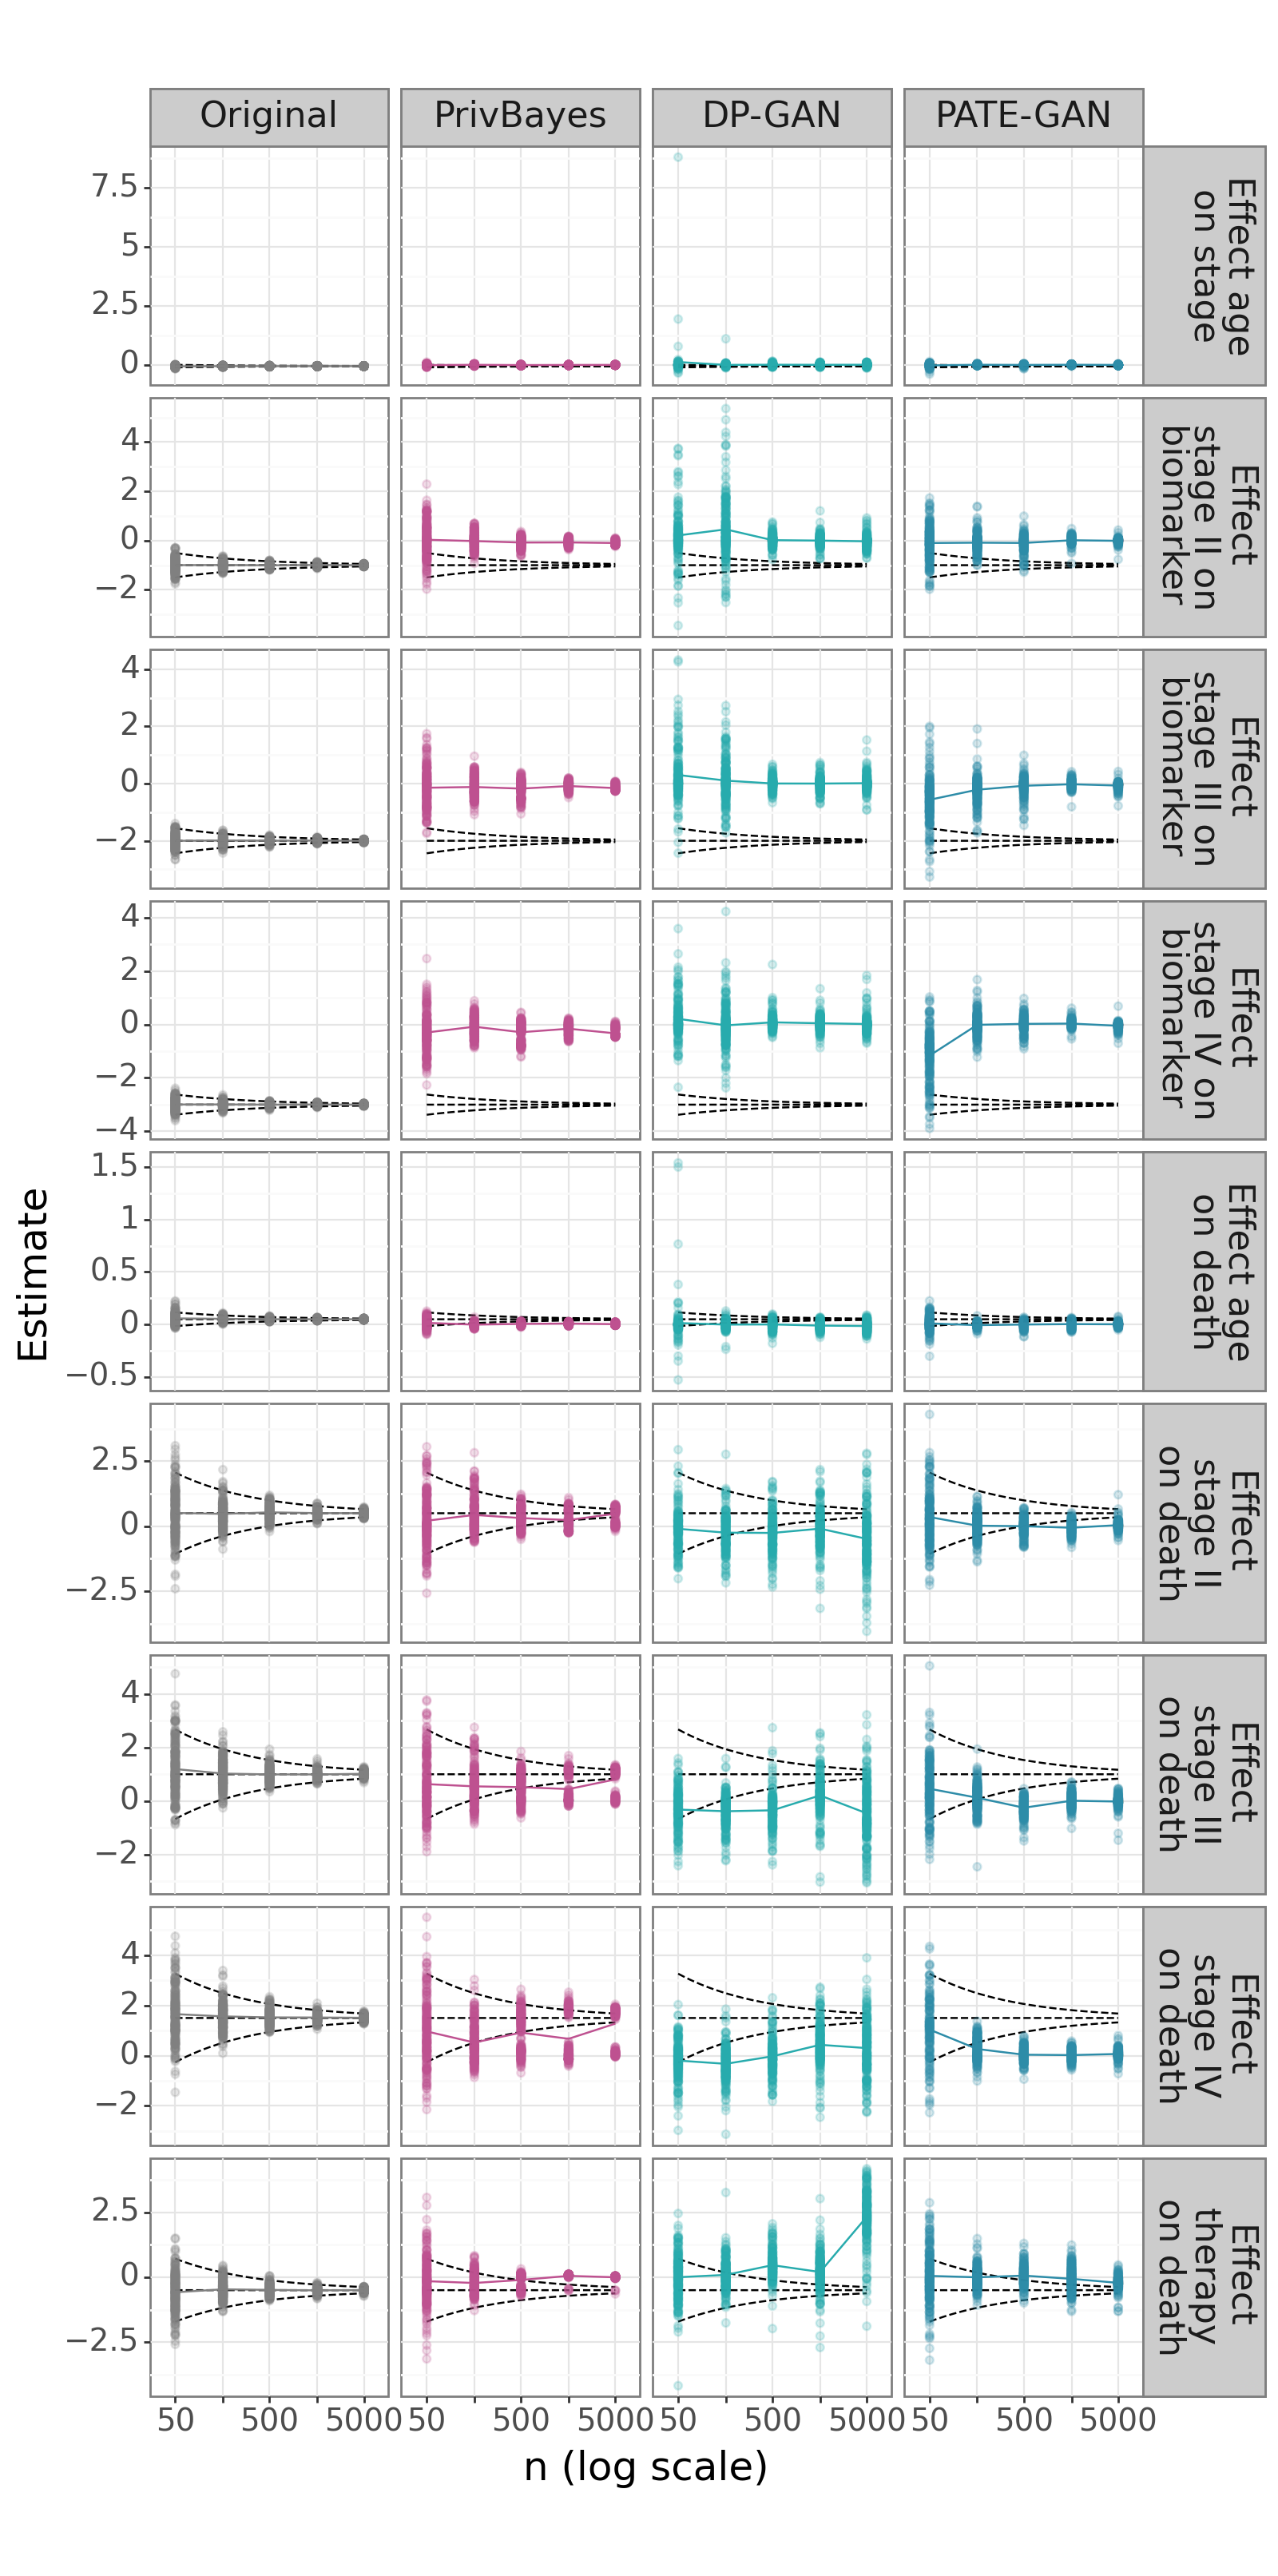

<Figure Size: (800 x 1612)>

In [16]:
# Relabel
relabel_estimators = {'stage_age_polr': 'Effect age\non stage\n', 
                      'biomarker_stage_II_gamr': 'Effect\nstage II on\nbiomarker',
                      'biomarker_stage_III_gamr': 'Effect\nstage III on\nbiomarker',
                      'biomarker_stage_IV_gamr': 'Effect\nstage IV on\nbiomarker', 
                      'death_age_logr': 'Effect age\non death\n',
                      'death_stage_II_logr': 'Effect\nstage II\non death',
                      'death_stage_III_logr': 'Effect\nstage III\non death',
                      'death_stage_IV_logr': 'Effect\nstage IV\non death',
                      'death_therapy_logr': 'Effect\ntherapy\non death'}
relabel_generators = {'original': 'Original',
                      'privbayes': 'PrivBayes', 
                      'dpgan': 'DP-GAN',
                      'pategan': 'PATE-GAN'}

# Plot
plot_bias(meta_data.query('generator in [\'original\', \'privbayes\', \'dpgan\', \'pategan\']'),
          select_estimators=['stage_age_polr',
                             'biomarker_stage_II_gamr', 'biomarker_stage_III_gamr', 'biomarker_stage_IV_gamr',
                             'death_age_logr', 'death_stage_II_logr', 'death_stage_III_logr', 'death_stage_IV_logr', 'death_therapy_logr'],
          order_generators=['original', 'privbayes', 'dpgan', 'pategan'],
          plot_outliers=True,
          unit_rescale=data_rescale,
          plot_estimates=True,
          ground_truth=data_gt) +\
    scale_colour_manual(values={'original': '#808080', 'privbayes': '#BE5190', 'dpgan': '#27ABAD', 'pategan':'#2D8CA8'}) +\
    facet_grid('estimator ~ generator', scales='free', labeller=labeller(cols=lambda x: relabel_generators[x], rows=lambda x: relabel_estimators[x])) +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          strip_text_y=element_text(margin={'l': 3, 'r': 3, 'units': 'pt'}), # facet_grid margin
          axis_text=element_text(size=14)) # axis labels size 

## Relative errors

**Table synthpop, BN DAG and custom CTGAN (main text)**

In [17]:
# Presets
select_generators = ['synthpop', 'bayesian_network_DAG', 'custom_ctgan'] 
select_n = [50, 5000]
select_metrics = ['relative_bias', 'SE_underestimation']
order_columns = ['n', 'estimator'] + select_metrics
select_rows = ['age_mean', 'biomarker_mean', 'therapy_prop', 'death_prop', 'death_age_logr', 'death_therapy_logr']

# Display table
summary_data = summary_table(meta_data, ground_truth=data_gt, select_estimators=select_rows) 
se_underest = pd.DataFrame({})
for gen in select_generators:
    se_underest = pd.concat([se_underest,
                             summary_data.query(f'generator==\'{gen}\' & n in {select_n}')[order_columns].pivot(index='estimator', columns='n').loc[select_rows]],
                            axis=1)
(se_underest*100).style.format(precision=2) # in percentage

**Table synthpop, BN and BN DAG (appendix)**

In [18]:
# Presets
select_generators = ['synthpop', 'bayesian_network', 'bayesian_network_DAG'] 
select_n = [50, 5000]
select_metrics = ['relative_bias', 'SE_underestimation']
order_columns = ['n', 'estimator'] + select_metrics
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
summary_data = summary_table(meta_data, ground_truth=data_gt, select_estimators=select_rows) 
se_underest = pd.DataFrame({})
for gen in select_generators:
    se_underest = pd.concat([se_underest,
                             summary_data.query(f'generator==\'{gen}\' & n in {select_n}')[order_columns].pivot(index='estimator', columns='n').loc[select_rows]],
                            axis=1)
(se_underest*100).style.format(precision=2) # in percentage

**Table CTGAN and custom CTGAN (appendix)**

In [19]:
# Presets
select_generators = ['ctgan', 'custom_ctgan'] 
select_n = [50, 5000]
select_metrics = ['relative_bias', 'SE_underestimation']
order_columns = ['n', 'estimator'] + select_metrics
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
summary_data = summary_table(meta_data, ground_truth=data_gt, select_estimators=select_rows) 
se_underest = pd.DataFrame({})
for gen in select_generators:
    se_underest = pd.concat([se_underest,
                             summary_data.query(f'generator==\'{gen}\' & n in {select_n}')[order_columns].pivot(index='estimator', columns='n').loc[select_rows]],
                            axis=1)
(se_underest*100).style.format(precision=2) # in percentage

**Table TVAE and custom TVAE (appendix)**

In [20]:
# Presets
select_generators = ['tvae', 'custom_tvae'] 
select_n = [50, 5000]
select_metrics = ['relative_bias', 'SE_underestimation']
order_columns = ['n', 'estimator'] + select_metrics
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
summary_data = summary_table(meta_data, ground_truth=data_gt, select_estimators=select_rows) 
se_underest = pd.DataFrame({})
for gen in select_generators:
    se_underest = pd.concat([se_underest,
                             summary_data.query(f'generator==\'{gen}\' & n in {select_n}')[order_columns].pivot(index='estimator', columns='n').loc[select_rows]],
                            axis=1)
(se_underest*100).style.format(precision=2) # in percentage

## Convergence rate

**Table SE/bias (main text)**

In [21]:
# Presets
order_columns = ['original', 'synthpop', 'bayesian_network_DAG', 'custom_ctgan']
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = ['age_mean', 'biomarker_mean', 'therapy_prop', 'death_prop', 'death_age_logr', 'death_therapy_logr']

# Table SE
conv_rate_se = table_convergence_rate(meta_data,
                                      intercept=True,
                                      metric='se',
                                      round_decimals=2,
                                      show_ci=False).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Table bias
conv_rate_bias = table_convergence_rate(meta_data,
                                        intercept=True,
                                        metric='bias',
                                        round_decimals=2,
                                        show_ci=False).pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

# Display combined tables
conv_rate_bias.combine(conv_rate_se, lambda s1, s2: s1 + ' / ' + s2)

convergence rate                                    \
generator                  original     synthpop bayesian_network_DAG   
estimator                                                               
age_mean                0.64 / 0.49  0.38 / 0.53          0.45 / 0.49   
biomarker_mean          0.47 / 0.48  0.10 / 0.51          0.81 / 0.49   
therapy_prop            0.42 / 0.50  0.12 / 0.50          0.81 / 0.46   
death_prop              1.24 / 0.51  0.45 / 0.52          0.02 / 0.48   
death_age_logr          0.76 / 0.56  0.52 / 0.59         -0.07 / 0.57   
death_therapy_logr      0.70 / 0.53  0.52 / 0.56         -0.02 / 0.53   

                                  
generator           custom_ctgan  
estimator                         
age_mean            -0.42 / 0.40  
biomarker_mean       0.18 / 0.34  
therapy_prop         0.10 / 0.19  
death_prop           0.04 / 0.41  
death_age_logr      -0.00 / 0.47  
death_therapy_logr   0.00 / 0.51

**Table SE (appendix)**

In [22]:
# Presets
order_columns = ['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae'] 
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
conv_rate_se = table_convergence_rate(meta_data,
                                      intercept=True,
                                      metric='se',
                                      round_decimals=2,
                                      show_ci=True)
conv_rate_se.pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

convergence rate                     \
generator                          original           synthpop   
estimator                                                        
age_mean                  0.49 [0.47; 0.52]  0.53 [0.50; 0.55]   
biomarker_mean            0.48 [0.44; 0.53]  0.51 [0.44; 0.58]   
therapy_prop              0.50 [0.43; 0.56]  0.50 [0.46; 0.54]   
death_prop                0.51 [0.49; 0.53]  0.52 [0.49; 0.54]   
stage_I_prop              0.48 [0.43; 0.52]  0.54 [0.51; 0.57]   
stage_II_prop             0.48 [0.46; 0.51]  0.51 [0.47; 0.56]   
stage_III_prop            0.51 [0.46; 0.56]  0.51 [0.41; 0.61]   
stage_IV_prop             0.48 [0.44; 0.52]  0.47 [0.38; 0.57]   
stage_age_polr            0.53 [0.49; 0.56]  0.54 [0.48; 0.60]   
biomarker_stage_II_gamr   0.51 [0.47; 0.56]  0.54 [0.50; 0.58]   
biomarker_stage_III_gamr  0.50 [0.47; 0.54]  0.52 [0.46; 0.58]   
biomarker_stage_IV_gamr   0.50 [0.47; 0.53]  0.54 [0.49; 0.58]   
death_age_logr            0.56 [0.49; 0.63]  0.59 [0.45; 0.72]   
death_stage_II_logr       0.52 [0.47; 0.57]  0.56 [0.49; 0.63]   
death_stage_III_logr      0.52 [0.46; 0.59]  0.55 [0.47; 0.64]   
death_stage_IV_logr       0.53 [0.48; 0.57]  0.51 [0.43; 0.59]   
death_therapy_logr        0.53 [0.48; 0.58]  0.56 [0.49; 0.63]   

                                                                  \
generator                  bayesian_network bayesian_network_DAG   
estimator                                                          
age_mean                  0.49 [0.45; 0.52]    0.49 [0.47; 0.52]   
biomarker_mean            0.51 [0.48; 0.53]    0.49 [0.47; 0.51]   
therapy_prop              0.48 [0.46; 0.51]    0.46 [0.38; 0.54]   
death_prop                0.50 [0.44; 0.55]    0.48 [0.40; 0.55]   
stage_I_prop              0.46 [0.41; 0.52]    0.48 [0.43; 0.53]   
stage_II_prop             0.51 [0.49; 0.53]    0.47 [0.45; 0.49]   
stage_III_prop            0.56 [0.47; 0.64]    0.51 [0.45; 0.56]   
stage_IV_prop             0.49 [0.42; 0.55]    0.50 [0.46; 0.54]   
stage_age_polr            0.51 [0.48; 0.55]    0.48 [0.41; 0.55]   
biomarker_stage_II_gamr   0.55 [0.51; 0.60]    0.55 [0.52; 0.59]   
biomarker_stage_III_gamr  0.56 [0.52; 0.61]    0.55 [0.52; 0.58]   
biomarker_stage_IV_gamr   0.57 [0.50; 0.64]    0.52 [0.49; 0.55]   
death_age_logr            0.56 [0.45; 0.67]    0.57 [0.55; 0.59]   
death_stage_II_logr       0.55 [0.52; 0.57]    0.55 [0.50; 0.59]   
death_stage_III_logr      0.52 [0.48; 0.57]    0.55 [0.50; 0.60]   
death_stage_IV_logr       0.50 [0.49; 0.51]    0.52 [0.47; 0.56]   
death_therapy_logr        0.55 [0.47; 0.62]    0.53 [0.46; 0.59]   

                                                                   \
generator                               ctgan        custom_ctgan   
estimator                                                           
age_mean                   0.03 [-0.34; 0.41]   0.40 [0.13; 0.66]   
biomarker_mean             0.12 [-0.10; 0.35]   0.34 [0.26; 0.42]   
therapy_prop              -0.18 [-0.37; 0.01]  0.19 [-0.14; 0.52]   
death_prop                -0.09 [-0.28; 0.10]   0.41 [0.28; 0.53]   
stage_I_prop               0.13 [-0.02; 0.29]   0.28 [0.11; 0.44]   
stage_II_prop              0.06 [-0.17; 0.29]   0.26 [0.13; 0.39]   
stage_III_prop             0.18 [-0.16; 0.52]   0.29 [0.17; 0.41]   
stage_IV_prop               0.29 [0.16; 0.43]   0.29 [0.16; 0.41]   
stage_age_polr              0.20 [0.06; 0.33]   0.40 [0.30; 0.50]   
biomarker_stage_II_gamr     0.27 [0.08; 0.46]   0.55 [0.48; 0.61]   
biomarker_stage_III_gamr    0.16 [0.00; 0.31]   0.52 [0.44; 0.61]   
biomarker_stage_IV_gamr    0.10 [-0.19; 0.39]   0.55 [0.43; 0.67]   
death_age_logr              0.28 [0.12; 0.44]   0.47 [0.31; 0.63]   
death_stage_II_logr         0.30 [0.23; 0.36]   0.68 [0.41; 0.95]   
death_stage_III_logr        0.24 [0.13; 0.35]   0.65 [0.38; 0.93]   
death_stage_IV_logr         0.20 [0.14; 0.27]   0.71 [0.44; 0.97]   
death_therapy_logr          0.25 [

**Table bias (appendix)**

In [23]:
# Presets
order_columns = ['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae'] 
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
conv_rate_bias = table_convergence_rate(meta_data,
                                        intercept=True,
                                        metric='bias',
                                        round_decimals=2,
                                        show_ci=True)
conv_rate_bias.pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

convergence rate                       \
generator                           original             synthpop   
estimator                                                           
age_mean                   0.64 [0.40; 0.89]    0.38 [0.18; 0.58]   
biomarker_mean             0.47 [0.17; 0.77]   0.10 [-0.43; 0.63]   
therapy_prop               0.42 [0.09; 0.76]   0.12 [-0.52; 0.75]   
death_prop                 1.24 [0.64; 1.85]   0.45 [-0.52; 1.43]   
stage_I_prop              0.65 [-0.02; 1.32]   0.79 [-0.52; 2.09]   
stage_II_prop              0.92 [0.49; 1.36]    0.57 [0.46; 0.67]   
stage_III_prop            0.46 [-0.51; 1.43]   0.57 [-0.12; 1.27]   
stage_IV_prop             0.21 [-0.10; 0.51]   0.04 [-0.69; 0.77]   
stage_age_polr             0.76 [0.27; 1.25]   0.55 [-0.28; 1.39]   
biomarker_stage_II_gamr   0.05 [-0.71; 0.81]  -0.09 [-1.29; 1.12]   
biomarker_stage_III_gamr  0.02 [-0.87; 0.90]  -0.03 [-1.02; 0.95]   
biomarker_stage_IV_gamr   0.37 [-0.29; 1.03]   0.34 [-0.52; 1.19]   
death_age_logr            0.76 [-0.21; 1.74]   0.52 [-0.01; 1.05]   
death_stage_II_logr       0.49 [-0.27; 1.25]   0.81 [-0.00; 1.63]   
death_stage_III_logr      0.57 [-0.31; 1.45]    0.87 [0.14; 1.60]   
death_stage_IV_logr        0.62 [0.45; 0.79]  -0.16 [-1.37; 1.05]   
death_therapy_logr         0.70 [0.53; 0.87]    0.52 [0.11; 0.93]   

                                                                    \
generator                   bayesian_network  bayesian_network_DAG   
estimator                                                            
age_mean                   0.86 [0.39; 1.32]    0.45 [-0.61; 1.50]   
biomarker_mean            0.52 [-0.40; 1.44]     0.81 [0.20; 1.41]   
therapy_prop               0.63 [0.13; 1.14]    0.81 [-0.12; 1.74]   
death_prop                0.43 [-0.47; 1.34]    0.02 [-0.63; 0.67]   
stage_I_prop               0.72 [0.01; 1.42]    0.88 [-0.41; 2.18]   
stage_II_prop             0.91 [-0.24; 2.05]     0.76 [0.34; 1.17]   
stage_III_prop             0.47 [0.14; 0.81]     0.70 [0.40; 0.99]   
stage_IV_prop             1.01 [-0.76; 2.78]    0.47 [-0.23; 1.17]   
stage_age_polr            0.12 [-0.17; 0.42]    0.17 [-0.10; 0.44]   
biomarker_stage_II_gamr   0.54 [-0.11; 1.19]    0.20 [-0.25; 0.64]   
biomarker_stage_III_gamr  0.35 [-0.33; 1.04]     0.58 [0.09; 1.08]   
biomarker_stage_IV_gamr   0.90 [-0.36; 2.15]    0.15 [-0.05; 0.34]   
death_age_logr            0.16 [-0.48; 0.79]   -0.07 [-0.14; 0.01]   
death_stage_II_logr       0.34 [-0.34; 1.01]   -0.01 [-0.06; 0.05]   
death_stage_III_logr      0.14 [-1.65; 1.92]   -0.03 [-0.08; 0.01]   
death_stage_IV_logr        0.63 [0.32; 0.93]  -0.03 [-0.06; -0.00]   
death_therapy_logr        0.20 [-2.46; 2.86]   -0.02 [-0.07; 0.03]   

                                                                     \
generator                               ctgan          custom_ctgan   
estimator                                                             
age_mean                   0.08 [-0.61; 0.78]   -0.42 [-1.62; 0.77]   
biomarker_mean             0.42 [-0.34; 1.18]    0.18 [-0.07; 0.43]   
therapy_prop               0.17 [-0.18; 0.52]    0.10 [-0.34; 0.54]   
death_prop                -0.06 [-0.88; 0.75]    0.04 [-0.01; 0.09]   
stage_I_prop               0.58 [-0.02; 1.19]     0.11 [0.06; 0.17]   
stage_II_prop              0.41 [-0.48; 1.30]     0.10 [0.02; 0.19]   
stage_III_prop              0.66 [0.31; 1.02]     0.13 [0.06; 0.19]   
stage_IV_prop             -0.12 [-0.72; 0.48]     0.11 [0.07; 0.15]   
stage_age_polr            -0.80 [-2.48; 0.88]    0.01 [-0.01; 0.03]   
biomarker_stage_II_gamr    1.02 [-0.51; 2.56]    0.03 [-0.00; 0.06]   
biomarker_stage_III_gamr    0.43 [0.17; 0.69]    0.01 [-0.00; 0.03]   
biomarker_stage_IV_gamr     0.38 [0.15; 0.61]    0.01 [-0.01; 0.02]   
death_age_logr            -0.17 [-0.60; 0.25]   -0.00 [-0.02; 0.01]   
death_stage_II_logr       -0.08 [-0.69; 0.52]  -0.03 [-0.05; -0.00]   
death_stage_III_logr       0.14 [-0.37;

**Table SE DP generators (appendix)**

In [24]:
# Presets
order_columns = ['original', 'privbayes', 'dpgan', 'pategan']
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
conv_rate_bias = table_convergence_rate(meta_data,
                                        intercept=True,
                                        metric='se',
                                        round_decimals=2,
                                        show_ci=True)
conv_rate_bias.pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

convergence rate                      \
generator                          original           privbayes   
estimator                                                         
age_mean                  0.49 [0.47; 0.52]   0.50 [0.27; 0.73]   
biomarker_mean            0.48 [0.44; 0.53]   0.45 [0.37; 0.53]   
therapy_prop              0.50 [0.43; 0.56]   0.60 [0.36; 0.83]   
death_prop                0.51 [0.49; 0.53]   0.58 [0.45; 0.70]   
stage_I_prop              0.48 [0.43; 0.52]  0.09 [-0.08; 0.25]   
stage_II_prop             0.48 [0.46; 0.51]   0.55 [0.41; 0.69]   
stage_III_prop            0.51 [0.46; 0.56]   0.15 [0.01; 0.29]   
stage_IV_prop             0.48 [0.44; 0.52]  0.05 [-0.20; 0.30]   
stage_age_polr            0.53 [0.49; 0.56]   0.52 [0.50; 0.54]   
biomarker_stage_II_gamr   0.51 [0.47; 0.56]   0.53 [0.44; 0.61]   
biomarker_stage_III_gamr  0.50 [0.47; 0.54]   0.47 [0.35; 0.59]   
biomarker_stage_IV_gamr   0.50 [0.47; 0.53]   0.34 [0.21; 0.47]   
death_age_logr            0.56 [0.49; 0.63]   0.34 [0.15; 0.54]   
death_stage_II_logr       0.52 [0.47; 0.57]   0.28 [0.12; 0.44]   
death_stage_III_logr      0.52 [0.46; 0.59]   0.18 [0.03; 0.33]   
death_stage_IV_logr       0.53 [0.48; 0.57]  0.08 [-0.09; 0.25]   
death_therapy_logr        0.53 [0.48; 0.58]   0.55 [0.39; 0.71]   

                                                                     
generator                                dpgan              pategan  
estimator                                                            
age_mean                    0.06 [-0.17; 0.30]   0.04 [-0.18; 0.26]  
biomarker_mean              0.02 [-0.18; 0.22]   0.07 [-0.11; 0.25]  
therapy_prop              -0.18 [-0.30; -0.07]  -0.02 [-0.08; 0.03]  
death_prop                 -0.14 [-0.31; 0.02]  -0.08 [-0.25; 0.09]  
stage_I_prop               -0.07 [-0.29; 0.15]   0.05 [-0.11; 0.20]  
stage_II_prop             -0.26 [-0.44; -0.09]   0.10 [-0.07; 0.27]  
stage_III_prop            -0.18 [-0.34; -0.02]    0.14 [0.01; 0.27]  
stage_IV_prop             -0.26 [-0.29; -0.23]   0.12 [-0.00; 0.25]  
stage_age_polr              0.60 [-0.12; 1.31]    0.36 [0.01; 0.71]  
biomarker_stage_II_gamr     0.41 [-0.04; 0.85]    0.42 [0.29; 0.56]  
biomarker_stage_III_gamr    0.33 [-0.05; 0.70]    0.45 [0.31; 0.59]  
biomarker_stage_IV_gamr     0.25 [-0.03; 0.53]    0.46 [0.26; 0.66]  
death_age_logr              0.27 [-0.19; 0.73]   0.21 [-0.14; 0.55]  
death_stage_II_logr        -0.07 [-0.21; 0.07]    0.38 [0.20; 0.55]  
death_stage_III_logr       -0.10 [-0.26; 0.07]    0.36 [0.18; 0.54]  
death_stage_IV_logr        -0.08 [-0.21; 0.04]    0.42 [0.15; 0.69]  
death_therapy_logr         -0.04 [-0.27; 0.19]   0.25 [-0.03; 0.52]

**Table bias DP generators (appendix)**

In [25]:
# Presets
order_columns = ['original', 'privbayes', 'dpgan', 'pategan']
order_columns = [('convergence rate', generator) for generator in order_columns]
select_rows = [column[:-len('_bias')] for column in meta_data.columns if 'bias' in column]

# Display table
conv_rate_bias = table_convergence_rate(meta_data,
                                        intercept=True,
                                        metric='bias',
                                        round_decimals=2,
                                        show_ci=True)
conv_rate_bias.pivot(index='estimator', columns='generator').loc[select_rows,order_columns]

convergence rate                       \
generator                           original            privbayes   
estimator                                                           
age_mean                   0.64 [0.40; 0.89]   0.05 [-0.77; 0.87]   
biomarker_mean             0.47 [0.17; 0.77]   0.46 [-0.30; 1.23]   
therapy_prop               0.42 [0.09; 0.76]   0.37 [-0.58; 1.32]   
death_prop                 1.24 [0.64; 1.85]   0.86 [-0.76; 2.49]   
stage_I_prop              0.65 [-0.02; 1.32]  -0.13 [-0.69; 0.43]   
stage_II_prop              0.92 [0.49; 1.36]   0.15 [-0.41; 0.71]   
stage_III_prop            0.46 [-0.51; 1.43]   0.11 [-0.31; 0.54]   
stage_IV_prop             0.21 [-0.10; 0.51]  -0.24 [-1.15; 0.67]   
stage_age_polr             0.76 [0.27; 1.25]  -0.03 [-0.12; 0.07]   
biomarker_stage_II_gamr   0.05 [-0.71; 0.81]    0.03 [0.01; 0.05]   
biomarker_stage_III_gamr  0.02 [-0.87; 0.90]  -0.00 [-0.02; 0.02]   
biomarker_stage_IV_gamr   0.37 [-0.29; 1.03]   0.00 [-0.03; 0.04]   
death_age_logr            0.76 [-0.21; 1.74]  -0.03 [-0.16; 0.09]   
death_stage_II_logr       0.49 [-0.27; 1.25]   0.36 [-0.50; 1.22]   
death_stage_III_logr      0.57 [-0.31; 1.45]   0.09 [-0.24; 0.43]   
death_stage_IV_logr        0.62 [0.45; 0.79]   0.16 [-0.26; 0.59]   
death_therapy_logr         0.70 [0.53; 0.87]  -0.12 [-0.27; 0.02]   

                                                                      
generator                                dpgan               pategan  
estimator                                                             
age_mean                    0.63 [-0.45; 1.71]   -0.39 [-1.21; 0.43]  
biomarker_mean            -0.40 [-0.55; -0.26]  -0.45 [-0.89; -0.00]  
therapy_prop                0.01 [-1.21; 1.23]   -0.19 [-0.67; 0.29]  
death_prop                -0.29 [-0.47; -0.12]    0.35 [-0.23; 0.92]  
stage_I_prop               -0.58 [-1.20; 0.04]   -0.71 [-1.75; 0.33]  
stage_II_prop               0.23 [-0.43; 0.90]    0.18 [-0.25; 0.62]  
stage_III_prop             -0.06 [-0.68; 0.56]   -0.30 [-0.85; 0.25]  
stage_IV_prop              -0.33 [-0.75; 0.09]   -0.10 [-0.74; 0.53]  
stage_age_polr              0.19 [-0.15; 0.53]   -0.08 [-0.27; 0.10]  
biomarker_stage_II_gamr     0.07 [-0.03; 0.17]   -0.03 [-0.05; 0.00]  
biomarker_stage_III_gamr    0.03 [-0.00; 0.06]   -0.06 [-0.12; 0.00]  
biomarker_stage_IV_gamr     0.01 [-0.01; 0.03]   -0.08 [-0.22; 0.05]  
death_age_logr            -0.12 [-0.19; -0.04]   -0.02 [-0.13; 0.09]  
death_stage_II_logr        -0.07 [-0.22; 0.08]   -0.21 [-0.56; 0.14]  
death_stage_III_logr        0.03 [-0.18; 0.25]   -0.12 [-0.32; 0.08]  
death_stage_IV_logr          0.11 [0.00; 0.21]   -0.21 [-0.49; 0.07]  
death_therapy_logr         -0.32 [-0.65; 0.02]    0.13 [-0.01; 0.27]

**Plot SE (appendix)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.



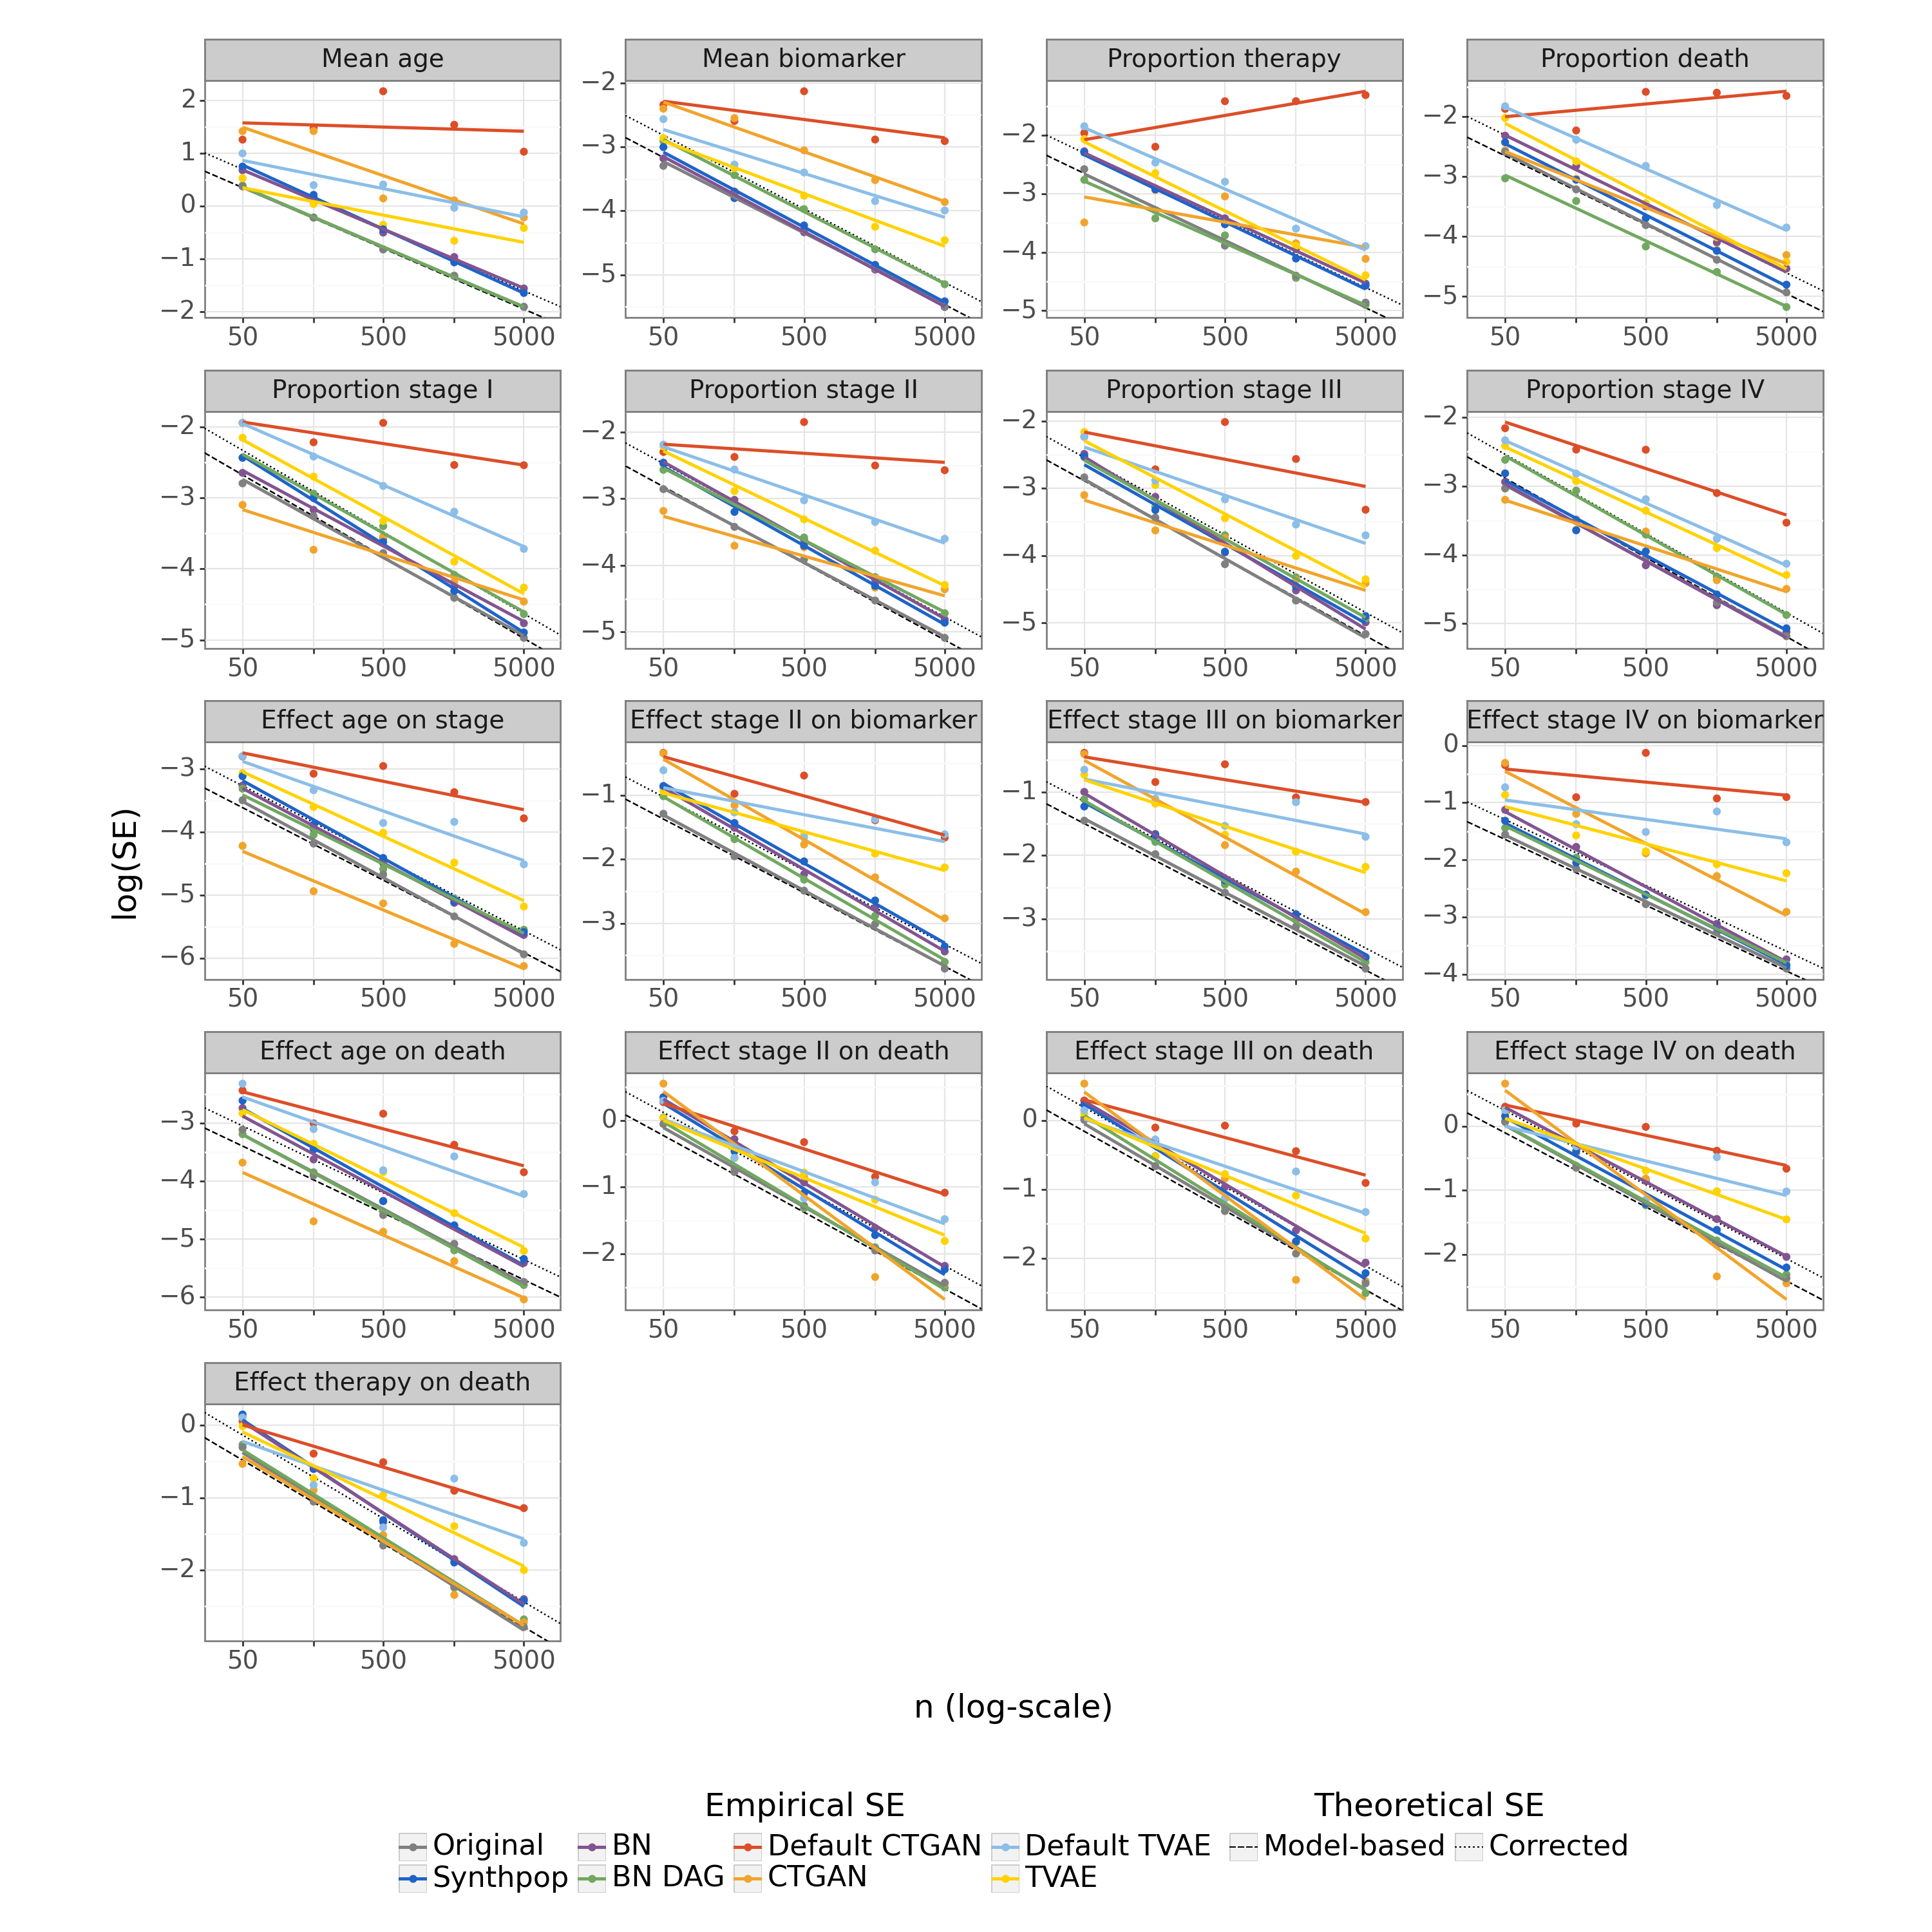

<Figure Size: (1500 x 1500)>

In [26]:
# Relabel
relabel_estimators = {'age_mean_bias': 'Mean age',
                      'biomarker_mean_bias': 'Mean biomarker',
                      'therapy_prop_bias': 'Proportion therapy',
                      'death_prop_bias': 'Proportion death', 
                      'stage_I_prop_bias': 'Proportion stage I',
                      'stage_II_prop_bias': 'Proportion stage II',
                      'stage_III_prop_bias': 'Proportion stage III',
                      'stage_IV_prop_bias': 'Proportion stage IV',
                      'stage_age_polr_bias': 'Effect age on stage', 
                      'biomarker_stage_II_gamr_bias': 'Effect stage II on biomarker',
                      'biomarker_stage_III_gamr_bias': 'Effect stage III on biomarker',
                      'biomarker_stage_IV_gamr_bias': 'Effect stage IV on biomarker', 
                      'death_age_logr_bias': 'Effect age on death',
                      'death_stage_II_logr_bias': 'Effect stage II on death',
                      'death_stage_III_logr_bias': 'Effect stage III on death',
                      'death_stage_IV_logr_bias': 'Effect stage IV on death',
                      'death_therapy_logr_bias': 'Effect therapy on death'}

# Plot
plot_convergence_rate(meta_data.query('generator not in [\'privbayes\', \'dpgan\', \'pategan\']'),
                      select_estimators=['age_mean', 'biomarker_mean', 
                                         'therapy_prop', 'death_prop', 'stage_I_prop', 'stage_II_prop', 'stage_III_prop', 'stage_IV_prop',
                                         'stage_age_polr',
                                         'biomarker_stage_II_gamr', 'biomarker_stage_III_gamr', 'biomarker_stage_IV_gamr',
                                         'death_age_logr', 'death_stage_II_logr', 'death_stage_III_logr', 'death_stage_IV_logr', 'death_therapy_logr'],
                      order_generators=['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae'],
                      unit_rescale=data_rescale, 
                      metric='se', 
                      check_root_n=False,
                      figure_size=(15,15)) +\
    facet_wrap('estimator', ncol=4, scales='free', labeller=labeller(cols=lambda x: relabel_estimators[x])) +\
    labs(color='Empirical SE', linetype='Theoretical SE', x='n (log-scale)', y='log(SE)') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'synthpop': '#1E64C8', 'bayesian_network': '#825491', 'bayesian_network_DAG': '#71A860',
                                    'ctgan': '#DC4E28', 'custom_ctgan': '#F1A42B', 'tvae': '#8BBEE8', 'custom_tvae': '#FFD200'}, # relabel legend
                        labels=['Original', 'Synthpop', 'BN', 'BN DAG', 'Default CTGAN', 'CTGAN', 'Default TVAE', 'TVAE']) +\
    scale_linetype_manual(values={'naive': 'dashed', 'corrected': 'dotted'}, # relabel legend
                          labels=['Model-based', 'Corrected']) +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=14), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size
          legend_position='bottom',
          legend_title=element_text(size=18), # legend title size
          legend_title_align='center',
          legend_text=element_text(size=16)) # legend labels size

## Type 1 error and power

**Plot (main text)**

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'linetype' is already present.
Adding another scale for 'linetype',
which will replace the existing scale.

/data/gent/vo/001/gvo00171/python_lib/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


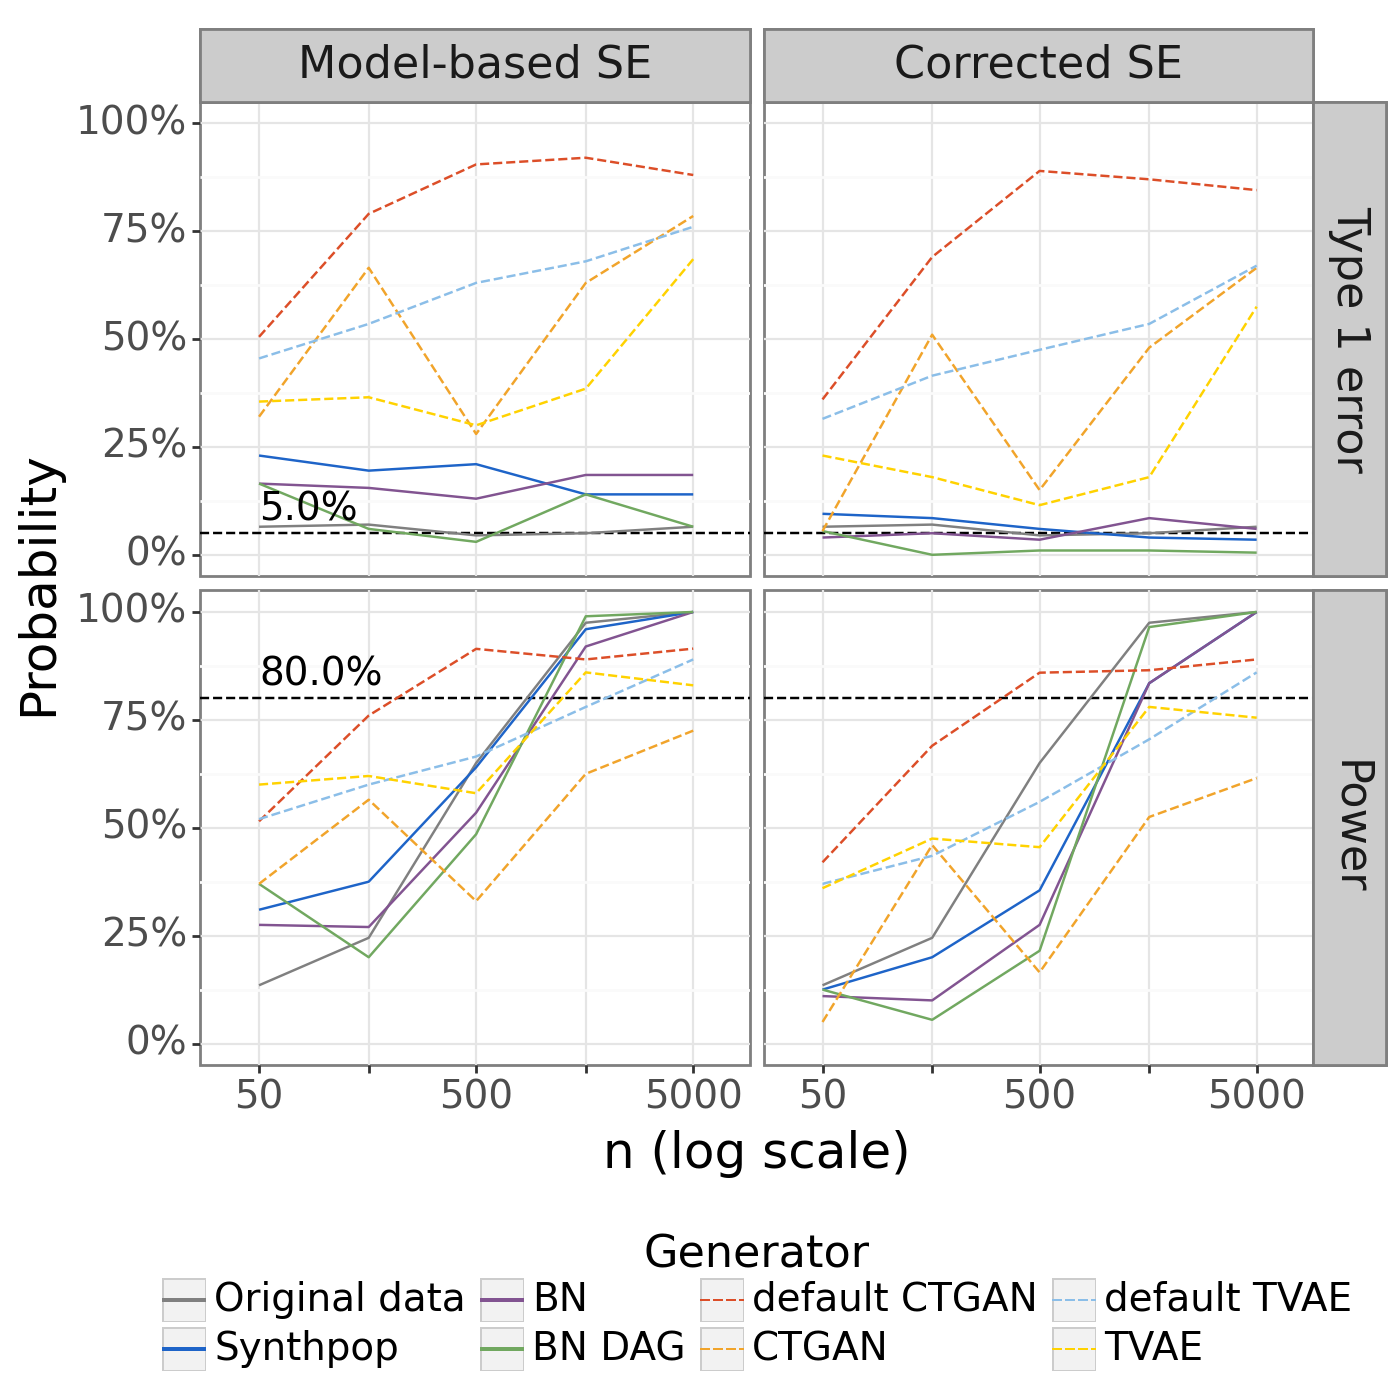

<Figure Size: (700 x 700)>

In [27]:
# Add text to vertical intercepts
intercepts_text = pd.DataFrame({'error': ['type 1 error', 'type 1 error', 'power', 'power'], 
                                'corrected': ['model-based SE', 'corrected SE', 'model-based SE', 'corrected SE'], 
                                'intercept': [0.05, np.nan, 0.80, np.nan], 
                                'generator': ['original']*4}) 
intercepts_text['label'] = intercepts_text.apply(lambda i: str(i['intercept']*100) + '%', axis=1)
intercepts_text['corrected'] = pd.Categorical(intercepts_text['corrected'], categories=['model-based SE', 'corrected SE']) # change order (non-alphabetically)
intercepts_text['error'] = pd.Categorical(intercepts_text['error'], categories=['type 1 error', 'power']) # change order (non-alphabetically)

# Relabel
relabel_error = {'type 1 error': 'Type 1 error',
                 'power': 'Power'}
relabel_SE = {'model-based SE': 'Model-based SE',
              'corrected SE': 'Corrected SE'}

# Plot
plot_type_I_II_error(meta_data.query('generator not in [\'privbayes\', \'dpgan\', \'pategan\']'),
                     select_estimator='age_mean',
                     order_generators=['original', 'synthpop', 'bayesian_network', 'bayesian_network_DAG', 'ctgan', 'custom_ctgan', 'tvae', 'custom_tvae'],
                     use_power=True,
                     figure_size=(7,7)) +\
    facet_grid('error ~ corrected', labeller=labeller(error=lambda x:relabel_error[x], corrected=lambda x:relabel_SE[x])) +\
    geom_text(data=intercepts_text, mapping=aes(x=50, y='intercept.astype(float)+0.01', label='label'), ha='left', va='bottom', colour='black', size=14) +\
    labs(color='Generator', linetype='Generator', y='Probability') +\
    scale_x_continuous(limits=[35,7000], breaks=[50,160,500,1600,5000], labels=[50,'',500,'',5000], trans='log') +\
    scale_colour_manual(values={'original': '#808080', 'synthpop': '#1E64C8', 'bayesian_network': '#825491', 'bayesian_network_DAG': '#71A860',
                                'ctgan': '#DC4E28', 'custom_ctgan': '#F1A42B', 'tvae': '#8BBEE8', 'custom_tvae': '#FFD200'}, # relabel legend
                        labels = ['Original data', 'Synthpop', 'BN', 'BN DAG', 'default CTGAN', 'CTGAN', 'default TVAE', 'TVAE']) +\
    scale_linetype_manual(values={'original': 'solid', 'synthpop': 'solid', 'bayesian_network': 'solid', 'bayesian_network_DAG': 'solid', 
                                  'ctgan': 'dashed', 'custom_ctgan': 'dashed', 'tvae': 'dashed', 'custom_tvae': 'dashed'}, # relabel legend
                          labels = ['Original data', 'Synthpop', 'BN', 'BN DAG', 'default CTGAN', 'CTGAN', 'default TVAE', 'TVAE']) +\
    theme(plot_title=element_blank(), # title size
          axis_title=element_text(size=18), # axis title size
          strip_text=element_text(size=16), # facet_grid title size
          axis_text=element_text(size=14), # axis labels size
          legend_position='bottom',
          legend_title=element_text(size=16), # legend title size
          legend_title_align='center',
          legend_text=element_text(size=14)) # legend labels size

# Sanity check: common rows

**Table (appendix)**

In [28]:
meta_data.query('sanity_common_rows_proportion != 0 & generator != \'original\'')[['dataset_name', 'n', 'run', 'generator', 'sanity_common_rows_proportion']].sort_values(by=['generator', 'n'])

dataset_name     n      run         generator  \
717    bayesian_network_0    50   run_65  bayesian_network   
1124   bayesian_network_0    50  run_102  bayesian_network   
1520   bayesian_network_0    50  run_138  bayesian_network   
1608   bayesian_network_0    50  run_146  bayesian_network   
1949   bayesian_network_0    50  run_177  bayesian_network   
...                   ...   ...      ...               ...   
10811         privbayes_0  5000  run_183         privbayes   
10877         privbayes_0  5000  run_189         privbayes   
10943         privbayes_0  5000  run_195         privbayes   
10965         privbayes_0  5000  run_197         privbayes   
10987         privbayes_0  5000  run_199         privbayes   

       sanity_common_rows_proportion  
717                           0.0200  
1124                          0.0200  
1520                          0.0200  
1608                          0.0200  
1949                          0.0200  
...                              ...  
10811                         0.0002  
10877                         0.0002  
10943                         0.0002  
10965                         0.0002  
10987                         0.0004  

[227 rows x 5 columns]